# **Data Extraction via API**

In [2]:
from cryptocompare_files.blockchain_data import get_blockchain_data
from cryptocompare_files.ohlcv import get_ohlcv
import pandas as pd

fsyms = ['ETH', 'BTC', 'DOGE', 'MATIC']

# Collect data
ohlcv_data = pd.DataFrame()
blockchain_data = pd.DataFrame()

for fsym in fsyms:
    ohlcv_data_temp = get_ohlcv(fsym)
    ohlcv_data_temp['symbol'] = fsym
    ohlcv_data = pd.concat([ohlcv_data, ohlcv_data_temp])

    blockchain_data_temp = get_blockchain_data(fsym)
    blockchain_data = pd.concat([blockchain_data, blockchain_data_temp])

ohlcv_data = ohlcv_data.reset_index().drop(columns=['index'])

# Save into csv
blockchain_data.to_csv('data/blockchain_data.csv')
ohlcv_data.to_csv('data/ohlcv_data.csv')


---- Extracting price data for ETH ... ---- 

Run number: 1 

Response received
Date range: From 2017-02-24 00:00:00 To 2022-08-17 01:00:00
Run number: 2 

Response received
Date range: From 2011-09-04 01:00:00 To 2017-02-24 00:00:00
No more data received. Terminating the loop at run 2 

---- Extracting blockchain data for ETH ... ---- 

Run number: 1 

Response received
Date range: From 2017-02-24 00:00:00 To 2022-08-17 01:00:00
Run number: 2 

Response received
Date range: From 2011-09-04 01:00:00 To 2017-02-24 00:00:00
Run number: 3 

No more data received. Terminating the loop at run 3 

---- Extracting price data for BTC ... ---- 

Run number: 1 

Response received
Date range: From 2017-02-24 00:00:00 To 2022-08-17 01:00:00
Run number: 2 

Response received
Date range: From 2011-09-04 01:00:00 To 2017-02-24 00:00:00
Run number: 3 

Response received
Date range: From 2006-03-14 00:00:00 To 2011-09-04 01:00:00
No more data received. Terminating the loop at run 3 

---- Extracting bl

# **Feature Engineering and Feature Selection**

## Load data from CSV file

In [79]:
import pandas as pd

blockchain_data = pd.read_csv('data/blockchain_data.csv')
blockchain_data = blockchain_data.drop(columns=['Unnamed: 0', 'index', 'id'])
blockchain_data = blockchain_data.drop_duplicates(subset=['date', 'symbol'], keep='first')

ohlcv_data = pd.read_csv('data/ohlcv_data.csv')
ohlcv_data = ohlcv_data.drop(columns=['Unnamed: 0', 'level_0', 'time'])
ohlcv_data = ohlcv_data.drop_duplicates(subset=['date', 'symbol'], keep='first')

google_trends_eth = pd.read_csv('data/Google_Trends_historical_interest.csv')


# # Merge ohlcv and blockhain data
# df = pd.merge(ohlcv_data, blockchain_data, how='inner', on=['date', 'symbol'])


## Build Technical indicators and Target variables

In [80]:
fsyms = ['ETH', 'BTC', 'DOGE', 'MATIC']

from feature_engineering import build_features_TA, build_target

features = build_features_TA(ohlcv_data, fsyms)
outcomes = build_target(ohlcv_data, fsyms)

## Data pre-processing

In [88]:
import datetime

features_eth = features[features['symbol'] == 'ETH']
features_eth = features_eth.drop(columns=['symbol'])
features_eth['date'] = (features_eth.date.apply(
                        lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
                            .replace(
                                hour=0, 
                                minute=0, 
                                second=0, 
                                microsecond=0)
                                )
                        )

outcomes_eth = outcomes[outcomes['symbol'] == 'ETH']
outcomes_eth['date'] = outcomes_eth.date.apply(
                        lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
                            .replace(
                                hour=0, 
                                minute=0, 
                                second=0, 
                                microsecond=0)
                                )


features_eth_blockchain = blockchain_data[blockchain_data['symbol'] == 'ETH']

features_eth_blockchain = features_eth_blockchain.drop(columns=['symbol', 'time'])
features_eth_blockchain['date'] = features_eth_blockchain.date.apply(
                        lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
                            .replace(
                                hour=0, 
                                minute=0, 
                                second=0, 
                                microsecond=0)
                                )
ohlcv_eth = ohlcv_data[ohlcv_data['symbol'] == 'ETH']

ohlcv_eth['date'] = (ohlcv_eth.date.apply(
                        lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
                            .replace(
                                hour=0, 
                                minute=0, 
                                second=0, 
                                microsecond=0)
                                )
                        )

google_trends_eth['date'] = google_trends_eth['date'].apply( lambda x: datetime.datetime.strptime(x, '%d/%m/%Y %H:%M') )

google_trends_eth = google_trends_eth.set_index('date').resample('D').sum()
google_trends_eth = google_trends_eth.reset_index().drop(columns='isPartial')

features_eth = features_eth.set_index('date')
features_eth_blockchain = features_eth_blockchain.set_index('date')
google_trends_eth = google_trends_eth.set_index('date')
outcomes_eth = outcomes_eth.set_index('date')
ohlcv_eth = ohlcv_eth.set_index('date')

# nonnull_dates = outcomes_eth.merge(features_eth, how='inner', on='date').dropna().date
nonnull_index = outcomes_eth.merge(features_eth, how='inner', on='date').dropna().index


# Blockchain data Feature Engineering
cols_remove = ['transaction_count_all_time', 'unique_addresses_all_time', 'zero_balance_addresses_all_time', 'current_supply']

features_eth_blockchain['unique_addresses_pct_change'] = features_eth_blockchain['unique_addresses_all_time'].pct_change(1)
features_eth_blockchain['unique_addresses_diff'] = features_eth_blockchain['unique_addresses_all_time'].diff(1)
features_eth_blockchain['zero_balance_addresses_diff'] = features_eth_blockchain['zero_balance_addresses_all_time'].diff(1)
features_eth_blockchain['zero_balance_addresses_pct_change'] = features_eth_blockchain['zero_balance_addresses_all_time'].pct_change(1)

features_eth_blockchain['current_supply_pct_change'] = features_eth_blockchain['current_supply'].pct_change(1)
features_eth_blockchain['current_supply_diff'] = features_eth_blockchain['current_supply'].diff(1)

features_eth_blockchain['difficulty_pct_change'] = features_eth_blockchain['difficulty'].pct_change(1)

features_eth_blockchain = features_eth_blockchain.drop(columns=cols_remove)

# Remove NaNs
features_eth = features_eth.loc[nonnull_index, :]
features_eth_blockchain = features_eth_blockchain.loc[nonnull_index, :]
google_trends_eth = google_trends_eth.loc[nonnull_index, :]
outcomes_eth = outcomes_eth.loc[nonnull_index, :]
ohlcv_eth = ohlcv_eth.loc[nonnull_index, :]

# Reset indices
features_eth = features_eth.reset_index()
features_eth_blockchain = features_eth_blockchain.reset_index()
google_trends_eth = google_trends_eth.reset_index()
outcomes_eth = outcomes_eth.reset_index()
ohlcv_eth = ohlcv_eth.reset_index()



print(features_eth.shape, features_eth_blockchain.shape, outcomes_eth.shape, google_trends_eth.shape, ohlcv_eth.shape)


C:\Users\yesbo\AppData\Local\Temp\ipykernel_24744\1583870170.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outcomes_eth['date'] = outcomes_eth.date.apply(
C:\Users\yesbo\AppData\Local\Temp\ipykernel_24744\1583870170.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ohlcv_eth['date'] = (ohlcv_eth.date.apply(


(2501, 32) (2501, 18) (2501, 16) (2501, 3) (2501, 10)


## Plotting Technical Indicators

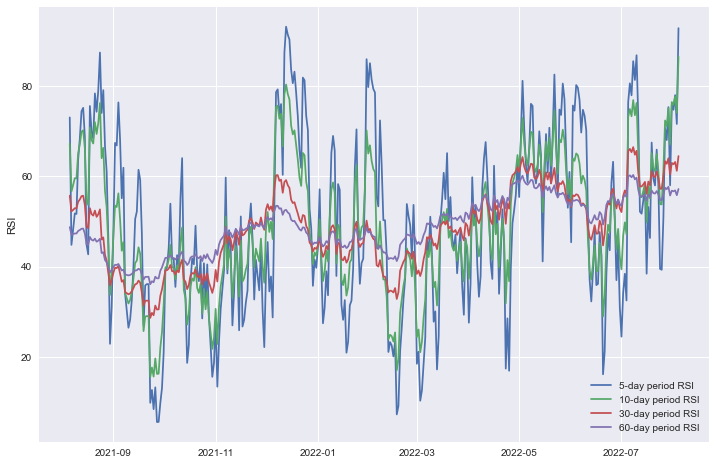

KeyError: 'ADI'

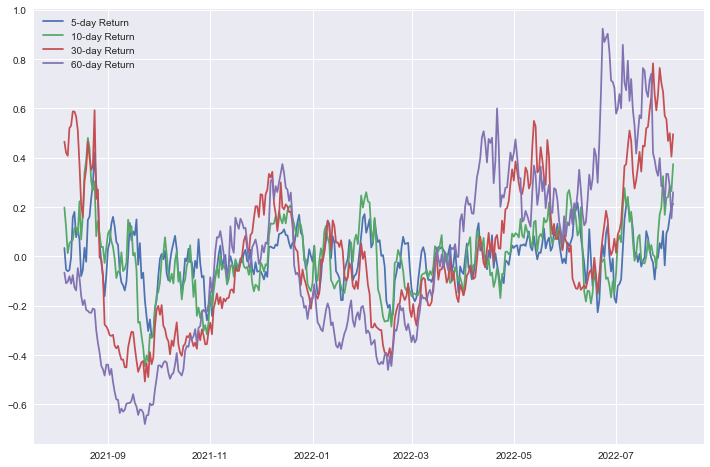

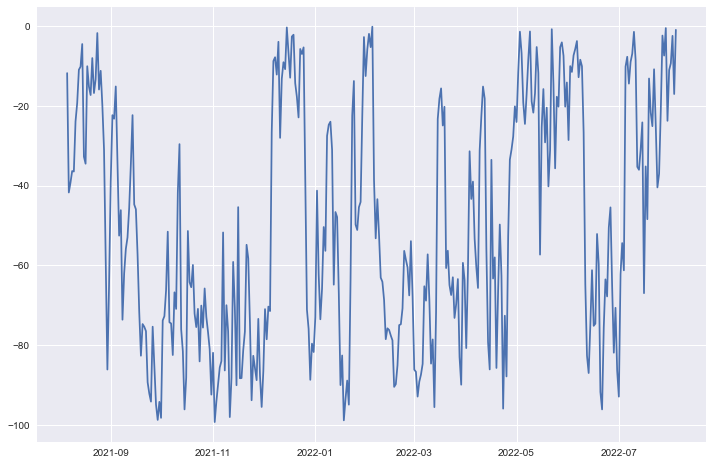

<Figure size 864x576 with 0 Axes>

In [5]:
import matplotlib.pyplot as plt

plt.style.use('seaborn')
plt.figure(figsize=(12, 8))
for i in [5, 10, 30, 60]:
    plt.plot(features_eth['date'][-365:-1], features_eth[f'rsi_{i}'][:-365:-1], label=f'{i}-day period RSI')
plt.legend()
plt.ylabel('RSI')
plt.show()

plt.figure(figsize=(12, 8))
for i in [5, 10, 30, 60]:
    plt.plot(features_eth['date'][-365:-1], features_eth[f'return_{i}'][:-365:-1], label=f'{i}-day Return')
plt.legend()

plt.figure(figsize=(12, 8))
plt.plot(features_eth['date'][-365:-1], features_eth['WILLR'][:-365:-1], label='Williams %R')

plt.figure(figsize=(12, 8))
plt.plot(features_eth['date'][-365:-1], features_eth['ADI'][:-365:-1], label='ADI')

# plt.legend()
# features_eth

# Exploratory Data Analysis

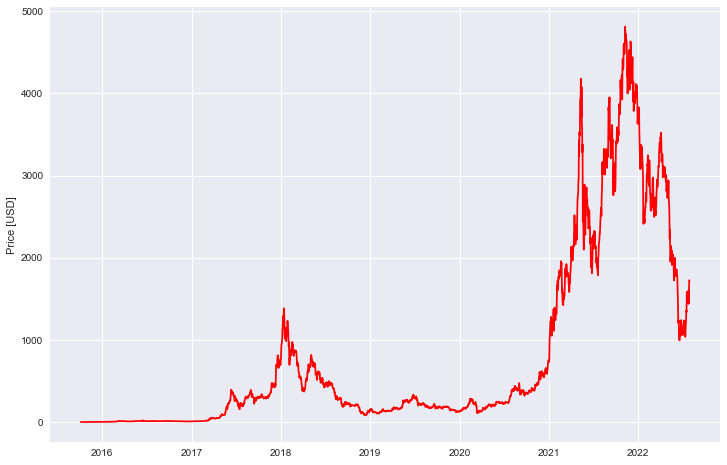

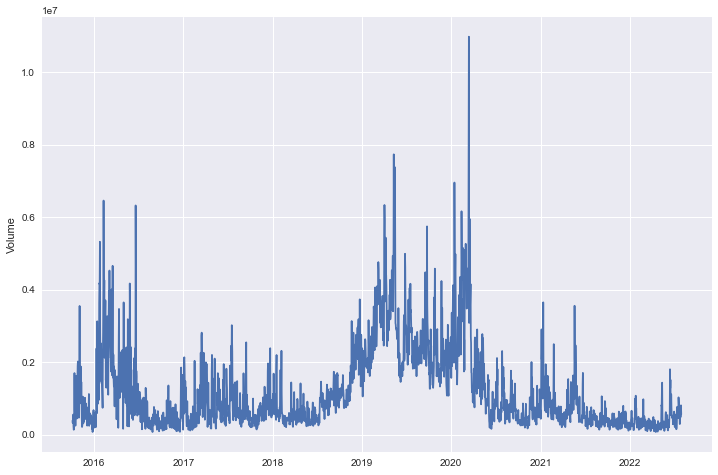

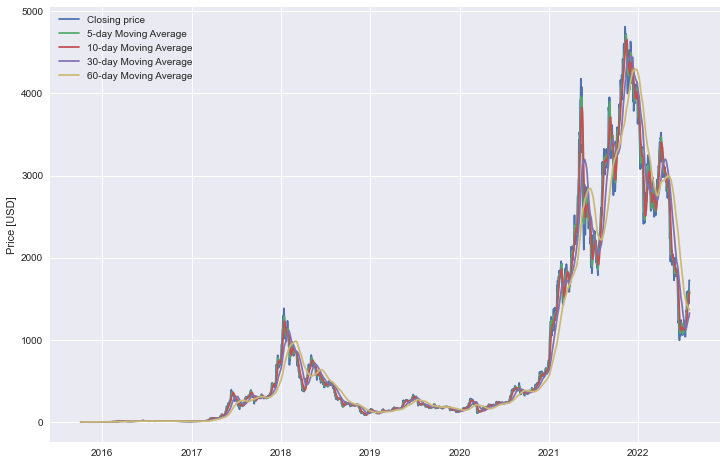

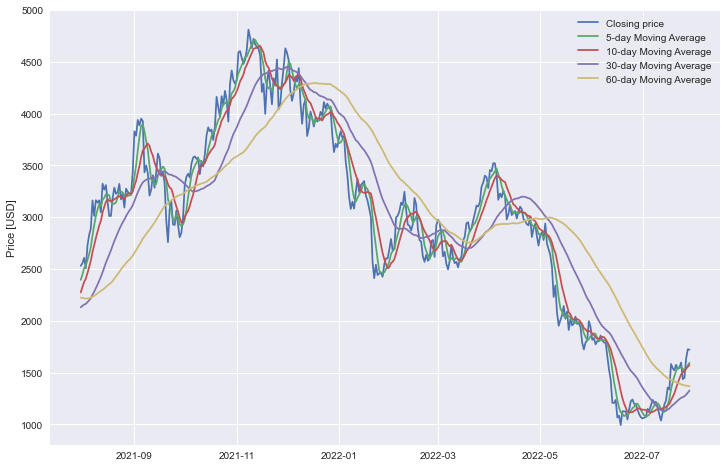

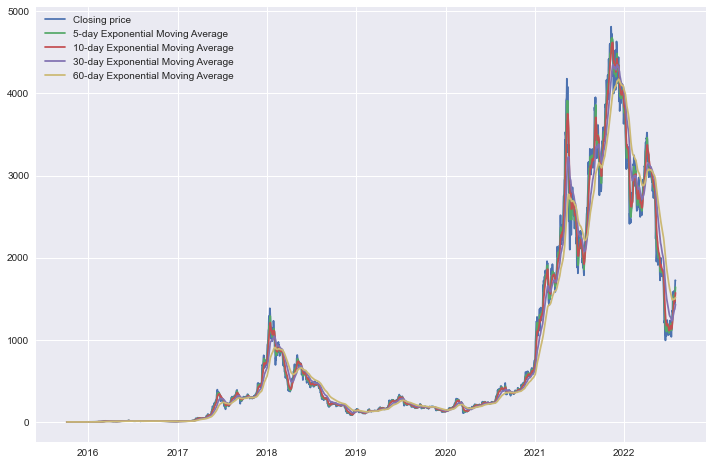

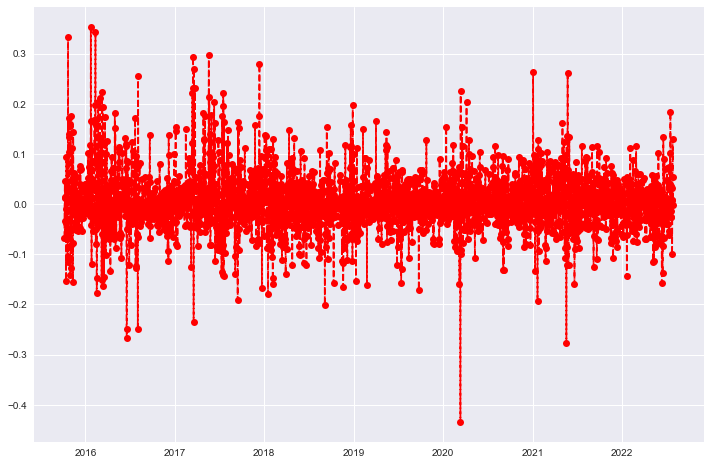

d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


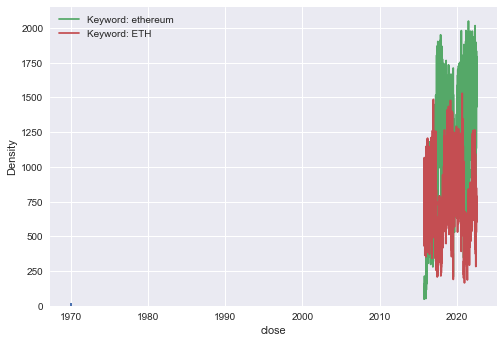

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
plt.figure(figsize=(12, 8))
plt.plot(ohlcv_eth['date'], ohlcv_eth['close'], color='red')
plt.ylabel('Price [USD]')
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(ohlcv_eth['date'], ohlcv_eth['volumefrom'])
plt.ylabel('Volume')

plt.figure(figsize=(12, 8))
plt.plot(ohlcv_eth['date'], ohlcv_eth['close'], label = 'Closing price')
plt.plot(ohlcv_eth['date'], features_eth['sma_5'], label='5-day Moving Average')
plt.plot(ohlcv_eth['date'], features_eth['sma_10'], label='10-day Moving Average')
plt.plot(ohlcv_eth['date'], features_eth['sma_30'], label='30-day Moving Average')
plt.plot(ohlcv_eth['date'], features_eth['sma_60'], label='60-day Moving Average')
plt.ylabel('Price [USD]')
plt.legend()

plt.figure(figsize=(12, 8))
plt.plot(ohlcv_eth[:-365:-1]['date'], ohlcv_eth[:-365:-1]['close'], label = 'Closing price')
plt.plot(ohlcv_eth[:-365:-1]['date'], features_eth[:-365:-1]['sma_5'], label='5-day Moving Average')
plt.plot(ohlcv_eth[:-365:-1]['date'], features_eth[:-365:-1]['sma_10'], label='10-day Moving Average')
plt.plot(ohlcv_eth[:-365:-1]['date'], features_eth[:-365:-1]['sma_30'], label='30-day Moving Average')
plt.plot(ohlcv_eth[:-365:-1]['date'], features_eth[:-365:-1]['sma_60'], label='60-day Moving Average')
plt.ylabel('Price [USD]')
plt.legend()



plt.figure(figsize=(12, 8))
plt.plot(ohlcv_eth['date'], ohlcv_eth['close'], label = 'Closing price')
plt.plot(ohlcv_eth['date'], features_eth['ema_5'], label='5-day Exponential Moving Average')
plt.plot(ohlcv_eth['date'], features_eth['ema_10'], label='10-day Exponential Moving Average')
plt.plot(ohlcv_eth['date'], features_eth['ema_30'], label='30-day Exponential Moving Average')
plt.plot(ohlcv_eth['date'], features_eth['ema_60'], label='60-day Exponential Moving Average')
plt.legend()


plt.figure(figsize=(12, 8))
plt.plot(ohlcv_eth['date'], ohlcv_eth['close'].pct_change(), label = 'Daily return', color = 'red', linestyle='--', marker='o')
plt.show()
plt.xlabel('Daily return')

sns.distplot(ohlcv_eth['close'].pct_change())



## Blockchain data

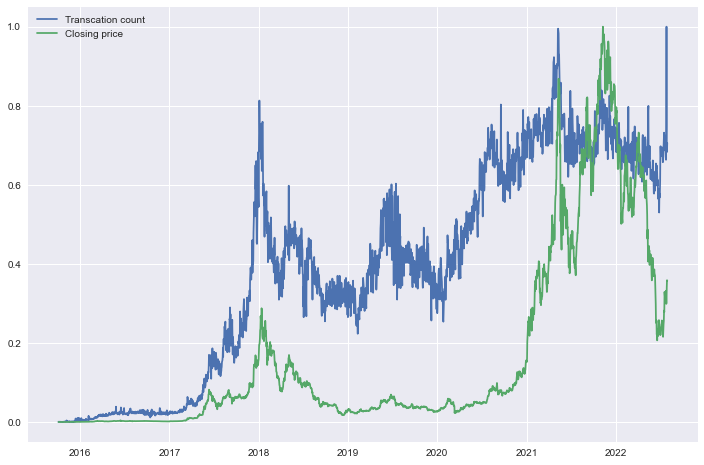

In [65]:
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler

import scipy 

scaler = MinMaxScaler()

plt.figure(figsize=(12, 8))

plt.plot(features_eth_blockchain['date'], scaler.fit_transform(features_eth_blockchain['transaction_count'].values.reshape(-1, 1)) , label='Transcation count')
plt.plot(features_eth_blockchain['date'], scaler.fit_transform(ohlcv_eth['close'].values.reshape(-1, 1)), label='Closing price')
plt.legend()

# plt.plot(features_eth_blockchain['date'], features_eth_blockchain['active_addresses'], label=' transaction count')



In [43]:
features_eth_blockchain


,date,zero_balance_addresses_all_time,unique_addresses_all_time,new_addresses,active_addresses,transaction_count,transaction_count_all_time,large_transaction_count,average_transaction_value,block_height,hashrate,difficulty,block_time,block_size,current_supply
0,2015-10-06,3755,23953,95,1554,6456,296291,0,78.481683,344703.0,0.349125,6.276470e+12,17.977732,781.0,7.382568e+07
1,2015-10-07,3767,24048,95,1511,7113,303404,0,43.614287,349707.0,0.346501,5.983538e+12,17.268439,808.0,7.385181e+07
2,2015-10-08,3787,24114,66,1459,6926,310330,0,45.260881,354859.0,0.356495,5.977784e+12,16.768200,788.0,7.387859e+07
3,2015-10-09,3803,24188,74,1489,6761,317091,0,33.183753,359764.0,0.347613,6.122632e+12,17.613377,779.0,7.390404e+07
4,2015-10-10,3820,24248,60,1407,6529,323620,0,19.715809,364660.0,0.341791,6.031582e+12,17.646987,777.0,7.392954e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2484,2022-07-25,144897712,224054199,76791,642692,1234425,1601894837,3449,2.164470,15214807.0,872.199982,1.178479e+16,13.511573,86433.0,1.216982e+08
2485,2022-07-26,144917617,224137991,83792,1098039,1640575,1603535412,3519,1.610106,15221187.0,873.683394,1.183260e+16,13.543345,84632.0,1.217116e+08
2486,2022-07-27,144952003,224239225,101234,569458,1161419,1604696831,4023,2.822379,15227620.0,879.212611,1.180882e+16,13.431126,81309.0,1.217251e+08
2487,2022-07-28,144988848,224317261,78036,537496,1122646,1605819477,5547,3.238220,15234058.0,894.239719,1.199993e+16,13.419139,84234.0,1.217387e+08


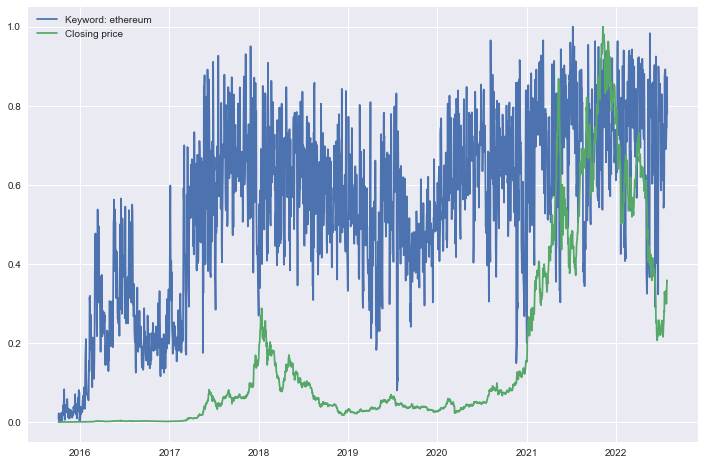

(-0.1, 0.1)

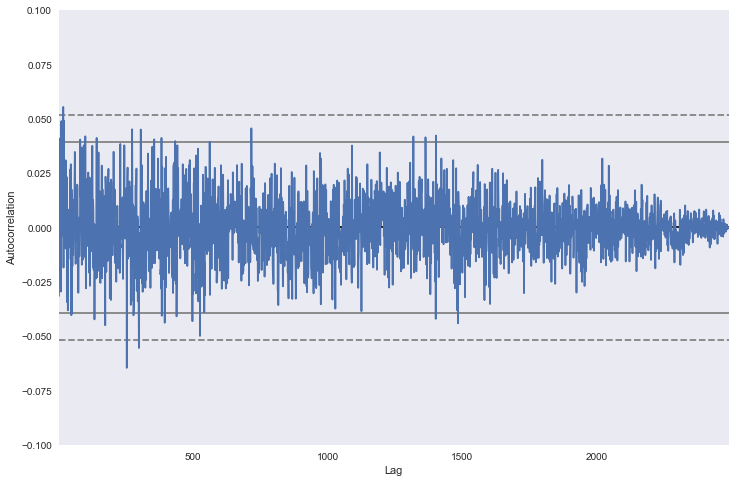

In [40]:
from pandas.plotting import autocorrelation_plot
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler

import scipy 

scaler = MinMaxScaler()

plt.style.use('seaborn')
plt.figure(figsize=(12, 8))

plt.plot(google_trends_eth['date'], scaler.fit_transform(google_trends_eth['ethereum'].values.reshape(-1, 1)) , label='Keyword: ethereum')
# plt.plot(google_trends_eth['date'], scaler.fit_transform(google_trends_eth['ETH'].values.reshape(-1, 1)), label='Keyword: ETH')
plt.plot(ohlcv_eth['date'], scaler.fit_transform(ohlcv_eth['close'].values.reshape(-1, 1)), label='Closing price')
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
autocorrelation_plot(outcomes_eth['close_1'])
plt.ylim(-0.1, 0.1)

# # T-test
# scipy.stats.ttest_ind(google_trends_eth['ethereum'], outcomes_eth['close_1'])

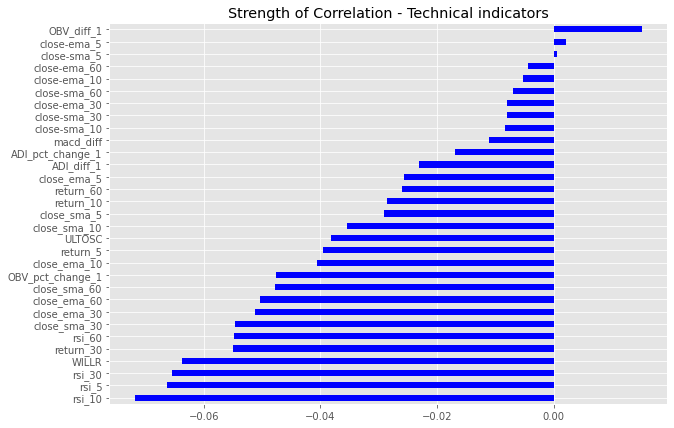

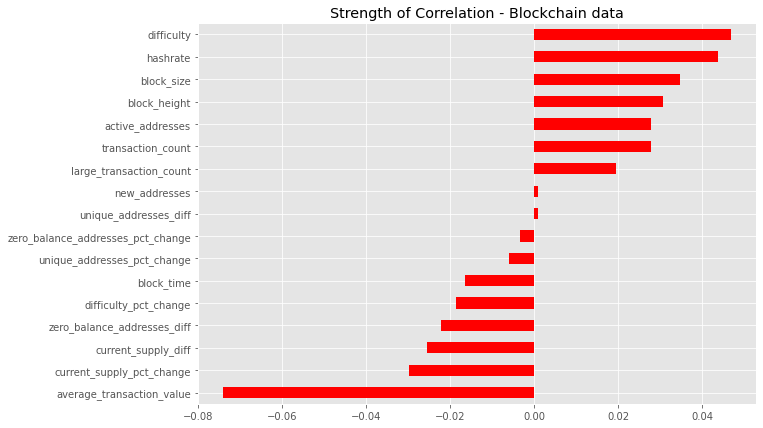

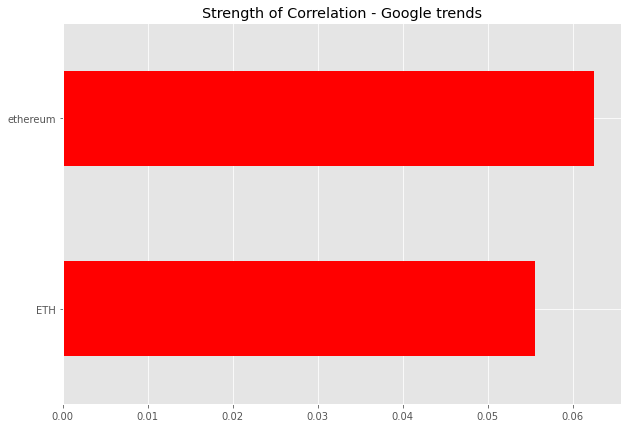

In [5]:
import matplotlib.pyplot as plt

# Correlation strength
plt.style.use('ggplot')

plt.figure(figsize=(10,7))

corr = features_eth.corrwith(outcomes_eth['close_1'])
corr.sort_values().plot.barh(color = 'blue', title = 'Strength of Correlation - Technical indicators')
plt.show()

plt.figure(figsize=(10,7))
plt.style.use('ggplot')
corr = features_eth_blockchain.corrwith(outcomes_eth['close_1'])
corr.sort_values().plot.barh(color = 'red', title = 'Strength of Correlation - Blockchain data')
plt.show()

plt.figure(figsize=(10,7))

plt.style.use('ggplot')
corr = google_trends_eth.corrwith(outcomes_eth['close_1'])
corr.sort_values().plot.barh(color = 'red', title = 'Strength of Correlation - Google trends')
plt.show()

Index(['date', 'return_5', 'close_sma_5', 'close_ema_5', 'return_10',
       'close_sma_10', 'close_ema_10', 'return_30', 'close_sma_30',
       'close_ema_30', 'return_60', 'close_sma_60', 'close_ema_60', 'rsi_5',
       'rsi_10', 'rsi_30', 'rsi_60', 'macd_diff', 'OBV', 'ADI', 'WILLR',
       'ULTOSC'],
      dtype='object')

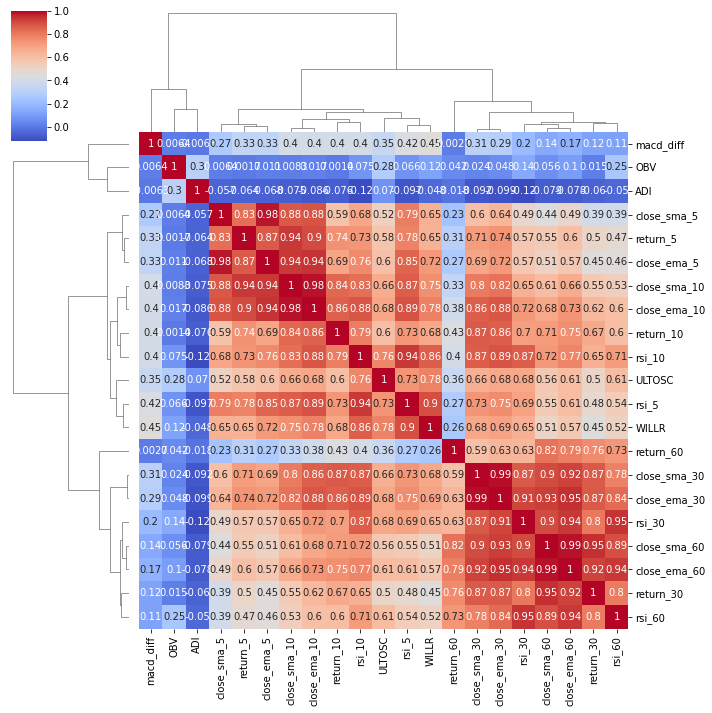

In [23]:
import seaborn as sns
from collinearity import SelectNonCollinear

#  Multicoliniarity

sns.clustermap(features_eth.drop(columns='date').corr(), cmap='coolwarm', annot=True, method='ward')




In [5]:
outcomes_eth

,date,symbol,close_1,direction_1,close_2,direction_2,close_3,direction_3,close_4,direction_4,close_5,direction_5,close_6,direction_6,close_7,direction_7
0,2015-10-06,ETH,0.071779,1.0,0.056406,1.0,0.010171,1.0,0.045621,1.0,0.033586,1.0,0.044788,1.0,0.086524,1.0
1,2015-10-07,ETH,-0.014343,0.0,-0.057482,0.0,-0.024406,0.0,-0.035635,0.0,-0.025183,0.0,0.013758,1.0,0.196401,1.0
2,2015-10-08,ETH,-0.043766,0.0,-0.010209,0.0,-0.021602,0.0,-0.010998,0.0,0.028510,1.0,0.213811,1.0,0.110018,1.0
3,2015-10-09,ETH,0.035093,1.0,0.023179,1.0,0.034268,1.0,0.075584,1.0,0.269366,1.0,0.160823,1.0,0.220196,1.0
4,2015-10-10,ETH,-0.011511,0.0,-0.000797,0.0,0.039118,1.0,0.226330,1.0,0.121467,1.0,0.178827,1.0,0.145651,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2491,2022-08-01,ETH,-0.000300,0.0,0.007376,1.0,0.014092,1.0,-0.061125,0.0,-0.035518,0.0,-0.041116,0.0,-0.082886,0.0
2492,2022-08-02,ETH,0.007679,1.0,0.014397,1.0,-0.060842,0.0,-0.035229,0.0,-0.040828,0.0,-0.082610,0.0,-0.042444,0.0
2493,2022-08-03,ETH,0.006667,1.0,-0.067999,0.0,-0.042581,0.0,-0.048138,0.0,-0.089601,0.0,-0.049741,0.0,-0.126949,0.0
2494,2022-08-04,ETH,-0.074172,0.0,-0.048921,0.0,-0.054442,0.0,-0.095630,0.0,-0.056035,0.0,-0.132731,0.0,-0.145184,0.0


# **Prediction models**

## *Construct datasets*

In [25]:
dataset_1 = features_eth
dataset_2 = features_eth_blockchain
dataset_3 = google_trends_eth
dataset_4 = features_eth.merge(features_eth_blockchain)
dataset_5 = dataset_4.merge(google_trends_eth)

## Baseline model (Momentum)

In [6]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

ohlcv_eth['direction_past_1'] = ohlcv_eth['close'].pct_change(1).apply(lambda x: 1 if x > 0 else (0 if x < 0 else None))
momentum_preds = ohlcv_eth.shift(1)[['date', 'direction_past_1']].set_index('date')
momentum_preds = momentum_preds.dropna()
y_true = outcomes_eth.set_index('date').loc[momentum_preds.index]['direction_1']

# accuracy_score(y_true, momentum_preds['direction_past_1'])

print('Accuracy:', round(accuracy_score(y_true, momentum_preds), 3))
print('F1 score:', round(f1_score(y_true, momentum_preds), 3))
print('Recall:', round(recall_score(y_true, momentum_preds), 3))
print('Precision:', round(precision_score(y_true, momentum_preds), 3))

# movements

Accuracy: 0.533
F1 score: 0.532
Recall: 0.544
Precision: 0.52


### *Run Predictions*


**List of models:**
- *Logistic Regression*
- *Support Vector Machines*
- *XGBoost Classifier*


## Dataset 1: Technical Indicators

In [5]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from run_predictions import fit_predict, evaluate_model, get_confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from lightgbm import LGBMClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import time
import logging

# Configure logging
logging.basicConfig(filename='training_models_d1.log',
                    filemode='a',
                    format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                    datefmt='%H:%M:%S',
                    level=logging.DEBUG)

train_periods = [30, 60, 100, 200]
test_periods = [1, 3, 7, 14]

models = {
            'Logistic Regression': LogisticRegression(), 
            'Support Vector Machines': SVC(), 
            'XGBoost Classifier': XGBClassifier()
        }

predictions = {}
train_time = {}
train_accuracies = {}

for train_period in train_periods:
    for test_period in test_periods:
        
        logging.info('Train period: {train_period}\t Test period: {test_period}\n'.format(train_period=train_period, test_period=test_period))
        
        for model in models:
            start = time.time()
            
            logging.info('Train period: {train_period}\t Test period: {test_period}\n'.format(train_period=train_period, test_period=test_period))
            print('Train period: {train_period}\t Test period: {test_period}\t Model: {model}\n'.format(train_period=train_period, test_period=test_period, model=model))

            index = '{train_period}_{test_period}_{model}'.format(train_period=train_period, test_period=test_period, model=model)

            logging.info('Running predictions for {model}'.format(model=model))

            predictions[index], train_accuracies[index] = fit_predict(
                models[model], dataset_1, outcomes_eth['direction_1'], train_period=train_period, test_period=test_period)
            
            end = time.time()

            logging.info('Time taken to train model {model} for train period {train_period} and test period {test_period}: {time_taken}'.format(model=model, train_period=train_period, test_period=test_period, time_taken=end-start))
            train_time[index] = end - start


metrics = {}
cm = {}

for model in predictions:
    y_true = outcomes_eth.set_index('date')['direction_1'].loc[predictions[model].index]
    print('Evaluating model {model}'.format(model=model))
    metrics[model] = evaluate_model(y_true=y_true, y_pred=list(predictions[model]))
    cm[model] = get_confusion_matrix(y_true=y_true, y_pred=list(predictions[model]))

    
pd.DataFrame(metrics).to_csv('metrics_dataset1_15Aug.csv')
pd.DataFrame(train_accuracies).to_csv('train_accuracies_dataset1_15Aug.csv')


Train period: 30	 Test period: 1	 Model: Logistic Regression

Train period: 30	 Test period: 1	 Model: Support Vector Machines

Train period: 30	 Test period: 1	 Model: XGBoost Classifier

Train period: 30	 Test period: 3	 Model: Logistic Regression

Train period: 30	 Test period: 3	 Model: Support Vector Machines

Train period: 30	 Test period: 3	 Model: XGBoost Classifier

Train period: 30	 Test period: 7	 Model: Logistic Regression

Train period: 30	 Test period: 7	 Model: Support Vector Machines

Train period: 30	 Test period: 7	 Model: XGBoost Classifier

Train period: 30	 Test period: 14	 Model: Logistic Regression

Train period: 30	 Test period: 14	 Model: Support Vector Machines

Train period: 30	 Test period: 14	 Model: XGBoost Classifier

Train period: 60	 Test period: 1	 Model: Logistic Regression

Train period: 60	 Test period: 1	 Model: Support Vector Machines

Train period: 60	 Test period: 1	 Model: XGBoost Classifier

Train period: 60	 Test period: 3	 Model: Logistic Re

In [78]:
outcomes_eth, ohlcv_eth

(           date   close_1  direction_1
 0    2015-10-05 -0.040885          0.0
 1    2015-10-06  0.071779          1.0
 2    2015-10-07 -0.014343          0.0
 3    2015-10-08 -0.043766          0.0
 4    2015-10-09  0.035093          1.0
 ...         ...       ...          ...
 2497 2022-08-06 -0.005804          0.0
 2498 2022-08-07 -0.043560          0.0
 2499 2022-08-08  0.043783          1.0
 2500 2022-08-09 -0.081249          0.0
 2501 2022-08-10       NaN          NaN
 
 [2502 rows x 3 columns],
            date       high        low       open  volumefrom      volumeto  \
 0    2015-10-05     0.6883     0.6189     0.6661   331312.10  2.083001e+05   
 1    2015-10-06     0.6587     0.6016     0.6287   385789.87  2.528740e+05   
 2    2015-10-07     0.6590     0.5955     0.6555   319267.37  1.952578e+05   
 3    2015-10-08     0.6419     0.5851     0.6116   473726.57  2.939566e+05   
 4    2015-10-09     0.6955     0.6238     0.6205   553115.65  3.589180e+05   
 ...         ...  

## Dataset 2: Blockchain Data

In [5]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from run_predictions import fit_predict, evaluate_model, get_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from lightgbm import LGBMClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import time
import logging

# Configure logging
logging.basicConfig(filename='training_models_d2.log',
                    filemode='a',
                    format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                    datefmt='%H:%M:%S',
                    level=logging.DEBUG)

train_periods = [30, 60, 100, 200]
test_periods = [1, 3, 7, 14]

models = {
            'Logistic Regression': LogisticRegression(), 
            'Support Vector Machines': SVC(), 
            'XGBoost Classifier': XGBClassifier()
        }

predictions = {}
train_time = {}
train_accuracies = {}

for train_period in train_periods:
    for test_period in test_periods:
        
        logging.info('Train period: {train_period}\t Test period: {test_period}\n'.format(train_period=train_period, test_period=test_period))
        
        for model in models:
            start = time.time()
            
            logging.info('Train period: {train_period}\t Test period: {test_period}\n'.format(train_period=train_period, test_period=test_period))
            print('Train period: {train_period}\t Test period: {test_period}\t Model: {model}\n'.format(train_period=train_period, test_period=test_period, model=model))

            index = '{train_period}_{test_period}_{model}'.format(train_period=train_period, test_period=test_period, model=model)

            logging.info('Running predictions for {model}'.format(model=model))

            predictions[index], train_accuracies[index] = fit_predict(
                models[model], dataset_2, outcomes_eth['direction_1'], train_period=train_period, test_period=test_period)
            
            end = time.time()

            logging.info('Time taken to train model {model} for train period {train_period} and test period {test_period}: {time_taken}'.format(model=model, train_period=train_period, test_period=test_period, time_taken=end-start))
            train_time[index] = end - start


metrics = {}
cm = {}

for model in predictions:
    y_true = outcomes_eth.set_index('date')['direction_1'].loc[predictions[model].index]
    print('Evaluating model {model}'.format(model=model))
    metrics[model] = evaluate_model(y_true=y_true, y_pred=list(predictions[model]))
    cm[model] = get_confusion_matrix(y_true=y_true, y_pred=list(predictions[model]))

    
pd.DataFrame(metrics).to_csv('metrics_dataset2.csv')
pd.DataFrame(train_accuracies).to_csv('evaluation_metrics/train_accuracies_d2.csv')

Train period: 30	 Test period: 1	 Model: Logistic Regression

Train period: 30	 Test period: 1	 Model: Support Vector Machines

Train period: 30	 Test period: 1	 Model: XGBoost Classifier

Train period: 30	 Test period: 3	 Model: Logistic Regression

Train period: 30	 Test period: 3	 Model: Support Vector Machines

Train period: 30	 Test period: 3	 Model: XGBoost Classifier

Train period: 30	 Test period: 7	 Model: Logistic Regression

Train period: 30	 Test period: 7	 Model: Support Vector Machines

Train period: 30	 Test period: 7	 Model: XGBoost Classifier

Train period: 30	 Test period: 14	 Model: Logistic Regression

Train period: 30	 Test period: 14	 Model: Support Vector Machines

Train period: 30	 Test period: 14	 Model: XGBoost Classifier

Train period: 60	 Test period: 1	 Model: Logistic Regression

Train period: 60	 Test period: 1	 Model: Support Vector Machines

Train period: 60	 Test period: 1	 Model: XGBoost Classifier

Train period: 60	 Test period: 3	 Model: Logistic Re

## Dataset 3: Google Trends

In [11]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from run_predictions import fit_predict, evaluate_model, get_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from lightgbm import LGBMClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import time
import logging

# Configure logging
logging.basicConfig(filename='training_models_d3.log',
                    filemode='a',
                    format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                    datefmt='%H:%M:%S',
                    level=logging.DEBUG)

train_periods = [30, 60, 100, 200]
test_periods = [1, 3, 7, 14]

models = {
            'Logistic Regression': LogisticRegression(), 
            'Support Vector Machines': SVC(), 
            'XGBoost Classifier': XGBClassifier()
        }

predictions = {}
train_time = {}
train_accuracies = {}

for train_period in train_periods:
    for test_period in test_periods:
        
        logging.info('Train period: {train_period}\t Test period: {test_period}\n'.format(train_period=train_period, test_period=test_period))
        
        for model in models:
            start = time.time()
            
            logging.info('Train period: {train_period}\t Test period: {test_period}\n'.format(train_period=train_period, test_period=test_period))
            print('Train period: {train_period}\t Test period: {test_period}\t Model: {model}\n'.format(train_period=train_period, test_period=test_period, model=model))

            index = '{train_period}_{test_period}_{model}'.format(train_period=train_period, test_period=test_period, model=model)

            logging.info('Running predictions for {model}'.format(model=model))

            predictions[index], train_accuracies[index] = fit_predict(
                models[model], dataset_3, outcomes_eth['direction_1'], train_period=train_period, test_period=test_period)
            
            end = time.time()

            logging.info('Time taken to train model {model} for train period {train_period} and test period {test_period}: {time_taken}'.format(model=model, train_period=train_period, test_period=test_period, time_taken=end-start))
            train_time[index] = end - start


metrics = {}
cm = {}

for model in predictions:
    y_true = outcomes_eth.set_index('date')['direction_1'].loc[predictions[model].index]
    print('Evaluating model {model}'.format(model=model))
    metrics[model] = evaluate_model(y_true=y_true, y_pred=list(predictions[model]))
    cm[model] = get_confusion_matrix(y_true=y_true, y_pred=list(predictions[model]))

    
pd.DataFrame(metrics).to_csv('evaluation_metrics/metrics_dataset3.csv')
pd.DataFrame(train_accuracies).to_csv('evaluation_metrics/train_accuracies_d3.csv')

Train period: 30	 Test period: 1	 Model: Logistic Regression

Train period: 30	 Test period: 1	 Model: Support Vector Machines

Train period: 30	 Test period: 1	 Model: XGBoost Classifier

Train period: 30	 Test period: 3	 Model: Logistic Regression

Train period: 30	 Test period: 3	 Model: Support Vector Machines

Train period: 30	 Test period: 3	 Model: XGBoost Classifier

Train period: 30	 Test period: 7	 Model: Logistic Regression

Train period: 30	 Test period: 7	 Model: Support Vector Machines

Train period: 30	 Test period: 7	 Model: XGBoost Classifier

Train period: 30	 Test period: 14	 Model: Logistic Regression

Train period: 30	 Test period: 14	 Model: Support Vector Machines

Train period: 30	 Test period: 14	 Model: XGBoost Classifier

Train period: 60	 Test period: 1	 Model: Logistic Regression

Train period: 60	 Test period: 1	 Model: Support Vector Machines

Train period: 60	 Test period: 1	 Model: XGBoost Classifier

Train period: 60	 Test period: 3	 Model: Logistic Re

## Dataset 4: Technical Indicators + On-chain metrics

In [5]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from run_predictions import fit_predict, evaluate_model, get_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from lightgbm import LGBMClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import time
import logging

# Configure logging
logging.basicConfig(filename='training_models_d4.log',
                    filemode='a',
                    format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                    datefmt='%H:%M:%S',
                    level=logging.DEBUG)

train_periods = [30, 60, 100, 200]
test_periods = [1, 3, 7, 14]

models = {
            'Logistic Regression': LogisticRegression(), 
            'Support Vector Machines': SVC(), 
            'XGBoost Classifier': XGBClassifier()
        }

predictions = {}
train_time = {}
train_accuracies = {}

for train_period in train_periods:
    for test_period in test_periods:
        
        logging.info('Train period: {train_period}\t Test period: {test_period}\n'.format(train_period=train_period, test_period=test_period))
        
        for model in models:
            start = time.time()
            
            logging.info('Train period: {train_period}\t Test period: {test_period}\n'.format(train_period=train_period, test_period=test_period))
            print('Train period: {train_period}\t Test period: {test_period}\t Model: {model}\n'.format(train_period=train_period, test_period=test_period, model=model))

            index = '{train_period}_{test_period}_{model}'.format(train_period=train_period, test_period=test_period, model=model)

            logging.info('Running predictions for {model}'.format(model=model))

            predictions[index], train_accuracies[index] = fit_predict(
                models[model], dataset_4, outcomes_eth['direction_1'], train_period=train_period, test_period=test_period)
            
            end = time.time()

            logging.info('Time taken to train model {model} for train period {train_period} and test period {test_period}: {time_taken}'.format(model=model, train_period=train_period, test_period=test_period, time_taken=end-start))
            train_time[index] = end - start


metrics = {}
cm = {}

for model in predictions:
    y_true = outcomes_eth.set_index('date')['direction_1'].loc[predictions[model].index]
    print('Evaluating model {model}'.format(model=model))
    metrics[model] = evaluate_model(y_true=y_true, y_pred=list(predictions[model]))
    cm[model] = get_confusion_matrix(y_true=y_true, y_pred=list(predictions[model]))

    
pd.DataFrame(metrics).to_csv('evaluation_metrics/metrics_dataset4.csv')
pd.DataFrame(train_accuracies).to_csv('evaluation_metrics/train_accuracies_d4.csv')

Train period: 30	 Test period: 1	 Model: Logistic Regression

Train period: 30	 Test period: 1	 Model: Support Vector Machines

Train period: 30	 Test period: 1	 Model: XGBoost Classifier

Train period: 30	 Test period: 3	 Model: Logistic Regression

Train period: 30	 Test period: 3	 Model: Support Vector Machines

Train period: 30	 Test period: 3	 Model: XGBoost Classifier

Train period: 30	 Test period: 7	 Model: Logistic Regression

Train period: 30	 Test period: 7	 Model: Support Vector Machines

Train period: 30	 Test period: 7	 Model: XGBoost Classifier

Train period: 30	 Test period: 14	 Model: Logistic Regression

Train period: 30	 Test period: 14	 Model: Support Vector Machines

Train period: 30	 Test period: 14	 Model: XGBoost Classifier

Train period: 60	 Test period: 1	 Model: Logistic Regression

Train period: 60	 Test period: 1	 Model: Support Vector Machines

Train period: 60	 Test period: 1	 Model: XGBoost Classifier

Train period: 60	 Test period: 3	 Model: Logistic Re

## Dataset 5: All features

In [5]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from run_predictions import fit_predict, evaluate_model, get_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from lightgbm import LGBMClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import time
import logging

# Configure logging
logging.basicConfig(filename='training_models_d5.log',
                    filemode='a',
                    format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                    datefmt='%H:%M:%S',
                    level=logging.DEBUG)

train_periods = [30, 60, 100, 200]
test_periods = [1, 3, 7, 14]

models = {
            'Logistic Regression': LogisticRegression(), 
            'Support Vector Machines': SVC(), 
            'XGBoost Classifier': XGBClassifier()
        }

predictions = {}
train_time = {}
train_accuracies = {}

for train_period in train_periods:
    for test_period in test_periods:
        
        logging.info('Train period: {train_period}\t Test period: {test_period}\n'.format(train_period=train_period, test_period=test_period))
        
        for model in models:
            start = time.time()
            
            logging.info('Train period: {train_period}\t Test period: {test_period}\n'.format(train_period=train_period, test_period=test_period))
            print('Train period: {train_period}\t Test period: {test_period}\t Model: {model}\n'.format(train_period=train_period, test_period=test_period, model=model))

            index = '{train_period}_{test_period}_{model}'.format(train_period=train_period, test_period=test_period, model=model)

            logging.info('Running predictions for {model}'.format(model=model))

            predictions[index], train_accuracies[index] = fit_predict(
                models[model], dataset_5, outcomes_eth['direction_1'], train_period=train_period, test_period=test_period)
            
            end = time.time()

            logging.info('Time taken to train model {model} for train period {train_period} and test period {test_period}: {time_taken}'.format(model=model, train_period=train_period, test_period=test_period, time_taken=end-start))
            train_time[index] = end - start


metrics = {}
cm = {}

for model in predictions:
    y_true = outcomes_eth.set_index('date')['direction_1'].loc[predictions[model].index]
    print('Evaluating model {model}'.format(model=model))
    metrics[model] = evaluate_model(y_true=y_true, y_pred=list(predictions[model]))
    cm[model] = get_confusion_matrix(y_true=y_true, y_pred=list(predictions[model]))

    
pd.DataFrame(metrics).to_csv('evaluation_metrics/metrics_dataset5.csv')
pd.DataFrame(train_accuracies).to_csv('evaluation_metrics/train_accuracies_d5.csv')

Train period: 30	 Test period: 1	 Model: Logistic Regression

Train period: 30	 Test period: 1	 Model: Support Vector Machines

Train period: 30	 Test period: 1	 Model: XGBoost Classifier

Train period: 30	 Test period: 3	 Model: Logistic Regression

Train period: 30	 Test period: 3	 Model: Support Vector Machines

Train period: 30	 Test period: 3	 Model: XGBoost Classifier

Train period: 30	 Test period: 7	 Model: Logistic Regression

Train period: 30	 Test period: 7	 Model: Support Vector Machines

Train period: 30	 Test period: 7	 Model: XGBoost Classifier

Train period: 30	 Test period: 14	 Model: Logistic Regression

Train period: 30	 Test period: 14	 Model: Support Vector Machines

Train period: 30	 Test period: 14	 Model: XGBoost Classifier

Train period: 60	 Test period: 1	 Model: Logistic Regression

Train period: 60	 Test period: 1	 Model: Support Vector Machines

Train period: 60	 Test period: 1	 Model: XGBoost Classifier

Train period: 60	 Test period: 3	 Model: Logistic Re

#  Dataset 1 Training: Additional features

In [167]:
import datetime
from feature_engineering_2 import build_features_TA


fsyms = ['ETH', 'BTC', 'DOGE', 'MATIC']
features_2 = build_features_TA(ohlcv_data, fsyms)


features_eth = features_2[features_2['symbol'] == 'ETH']
features_eth = features_eth.drop(columns=['symbol'])
features_eth['date'] = (features_eth.date.apply(
                        lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
                            .replace(
                                hour=0, 
                                minute=0, 
                                second=0, 
                                microsecond=0)
                                )
                        )

features_btc = features_2[features_2['symbol'] == 'BTC']
features_btc = features_btc.drop(columns=['symbol'])
features_btc['date'] = (features_btc.date.apply(
                        lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
                            .replace(
                                hour=0, 
                                minute=0, 
                                second=0, 
                                microsecond=0)
                                )
                        )

outcomes_eth = outcomes[outcomes['symbol'] == 'ETH']
outcomes_eth['date'] = outcomes_eth.date.apply(
                        lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
                            .replace(
                                hour=0, 
                                minute=0, 
                                second=0, 
                                microsecond=0)
                                )


ohlcv_eth = ohlcv_data[ohlcv_data['symbol'] == 'ETH']

ohlcv_eth['date'] = (ohlcv_eth.date.apply(
                        lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
                            .replace(
                                hour=0, 
                                minute=0, 
                                second=0, 
                                microsecond=0)
                                )
                        )

features_eth = features_eth.set_index('date')
outcomes_eth = outcomes_eth.set_index('date')
ohlcv_eth = ohlcv_eth.set_index('date')
features_btc = features_btc.set_index('date')


# nonnull_dates = outcomes_eth.merge(features_eth, how='inner', on='date').dropna().date
nonnull_index = outcomes_eth.merge(features_eth, how='inner', on='date').dropna().index


# Remove NaNs
features_eth = features_eth.loc[nonnull_index, :]
outcomes_eth = outcomes_eth.loc[nonnull_index, :]
ohlcv_eth = ohlcv_eth.loc[nonnull_index, :]
features_btc = features_btc.loc[nonnull_index, :]

# Reset indices
features_eth = features_eth.reset_index()
features_btc = features_btc.reset_index()

outcomes_eth = outcomes_eth.reset_index()
ohlcv_eth = ohlcv_eth.reset_index()

print(features_eth.shape, outcomes_eth.shape, ohlcv_eth.shape, features_btc.shape)


d:\UNI\Dissertation\simulations\feature_engineering_2.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features.loc[features['symbol'] == fsym,
d:\UNI\Dissertation\simulations\feature_engineering_2.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features.loc[features['symbol'] == fsym,
d:\UNI\Dissertation\simulations\feature_engineering_2.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns a

(2502, 455) (2502, 16) (2502, 10) (2502, 455)


C:\Users\yesbo\AppData\Local\Temp\ipykernel_24744\1951761738.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outcomes_eth['date'] = outcomes_eth.date.apply(
C:\Users\yesbo\AppData\Local\Temp\ipykernel_24744\1951761738.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ohlcv_eth['date'] = (ohlcv_eth.date.apply(


In [168]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from run_predictions import fit_predict, evaluate_model, get_confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from lightgbm import LGBMClassifier
import time
import logging

dataset_1 = features_eth
# solver='lbfgs', C=0.01, penalty='l2'
models = {
            'Logistic Regression': LogisticRegression(), 
            'Support Vector Machines': SVC(), 
            'XGBoost Classifier': XGBClassifier()
        }

predictions = {}
train_time = {}
train_accuracies = {}

train_period = 30
test_period = 3


for model in models:
    start = time.time()

    index = '{train_period}_{test_period}_{model}'.format(train_period=train_period, test_period=test_period, model=model)

    print('Running predictions for {model}'.format(model=model))

    predictions[model], train_accuracies[model] = fit_predict(
        models[model], dataset_1, outcomes_eth['direction_1'], train_period=train_period, test_period=test_period)
    
    end = time.time()

    logging.info('Time taken to train model {model} for train period {train_period} and test period {test_period}: {time_taken}'.format(model=model, train_period=train_period, test_period=test_period, time_taken=end-start))
    train_time[index] = end - start


metrics = {}
cm = {}

for model in predictions:
    y_true = outcomes_eth.set_index('date')['direction_1'].loc[predictions[model].index]
    print('Evaluating model {model}'.format(model=model))
    metrics[model] = evaluate_model(y_true=y_true, y_pred=list(predictions[model]))
    cm[model] = get_confusion_matrix(y_true=y_true, y_pred=list(predictions[model]))

metrics
# pd.DataFrame(metrics).to_csv('metrics_dataset1_15Aug.csv')
# pd.DataFrame(train_accuracies).to_csv('train_accuracies_dataset1_15Aug.csv')


Running predictions for Logistic Regression


d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

Running predictions for Support Vector Machines
Running predictions for XGBoost Classifier
Evaluating model Logistic Regression
Evaluating model Support Vector Machines
Evaluating model XGBoost Classifier


{'Logistic Regression': {'accuracy': 0.6978533819360064,
  'precision': 0.6939983093829247,
  'f1_score': 0.6876046901172529,
  'recall': 0.6813278008298755},
 'Support Vector Machines': {'accuracy': 0.6200891049007695,
  'precision': 0.6221408966148216,
  'f1_score': 0.5918189730200174,
  'recall': 0.5643153526970954},
 'XGBoost Classifier': {'accuracy': 0.6614013770757392,
  'precision': 0.6513535684987695,
  'f1_score': 0.6551155115511551,
  'recall': 0.6589211618257261}}

In [ ]:
metrics

In [ ]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from run_predictions import fit_predict, evaluate_model, get_confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from lightgbm import LGBMClassifier
import time
import logging

dataset_1 = features_eth
# solver='lbfgs', C=0.01, penalty='l2'
models = {
            'Logistic Regression': LogisticRegression(), 
            'Support Vector Machines': SVC(), 
            'XGBoost Classifier': XGBClassifier()
        }

predictions = {}
train_time = {}
train_accuracies = {}

train_period = 30
test_period = 3


for model in models:
    start = time.time()

    print('Running predictions for {model}'.format(model=model))

    predictions[model], train_accuracies[model] = fit_predict(
        models[model], dataset_1, outcomes_eth['direction_1'], train_period=train_period, test_period=test_period)
    
    end = time.time()

    logging.info('Time taken to train model {model} for train period {train_period} and test period {test_period}: {time_taken}'.format(model=model, train_period=train_period, test_period=test_period, time_taken=end-start))
    train_time[index] = end - start


metrics = {}
cm = {}

for model in predictions:
    y_true = outcomes_eth.set_index('date')['direction_1'].loc[predictions[model].index]
    print('Evaluating model {model}'.format(model=model))
    metrics[model] = evaluate_model(y_true=y_true, y_pred=list(predictions[model]))
    cm[model] = get_confusion_matrix(y_true=y_true, y_pred=list(predictions[model]))

metrics
# pd.DataFrame(metrics).to_csv('metrics_dataset1_15Aug.csv')
# pd.DataFrame(train_accuracies).to_csv('train_accuracies_dataset1_15Aug.csv')


In [27]:
predictions

{'Logistic Regression': date
 2015-11-05    0.0
 2015-11-06    1.0
 2015-11-07    1.0
 2015-11-08    1.0
 2015-11-09    1.0
              ... 
 2022-08-04    0.0
 2022-08-05    1.0
 2022-08-06    0.0
 2022-08-07    0.0
 2022-08-08    1.0
 Length: 2469, dtype: object,
 'Support Vector Machines': date
 2015-11-05    0.0
 2015-11-06    1.0
 2015-11-07    0.0
 2015-11-08    0.0
 2015-11-09    0.0
              ... 
 2022-08-04    0.0
 2022-08-05    1.0
 2022-08-06    0.0
 2022-08-07    0.0
 2022-08-08    1.0
 Length: 2469, dtype: object,
 'XGBoost Classifier': date
 2015-11-05    0
 2015-11-06    1
 2015-11-07    1
 2015-11-08    0
 2015-11-09    1
              ..
 2022-08-04    0
 2022-08-05    1
 2022-08-06    0
 2022-08-07    0
 2022-08-08    1
 Length: 2469, dtype: object}

## *Visualise Confusion matrix*

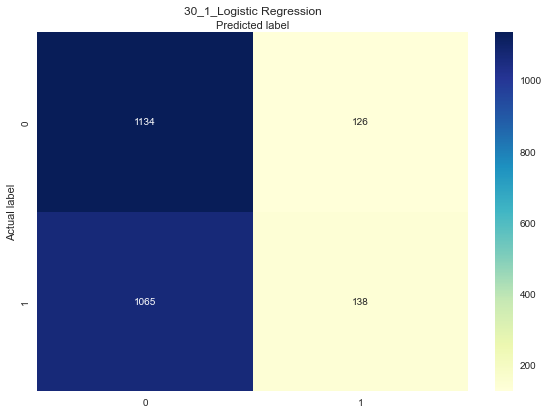

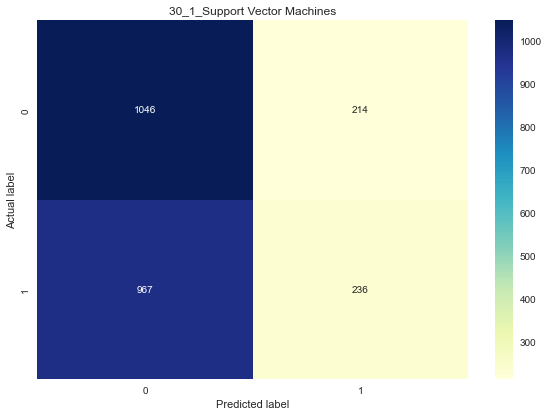

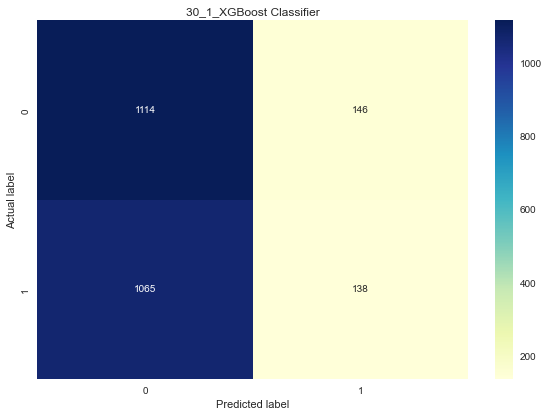

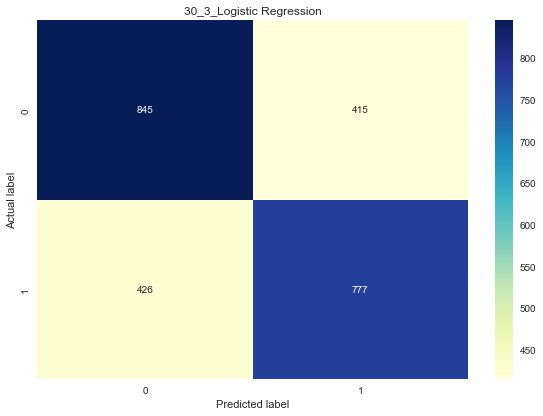

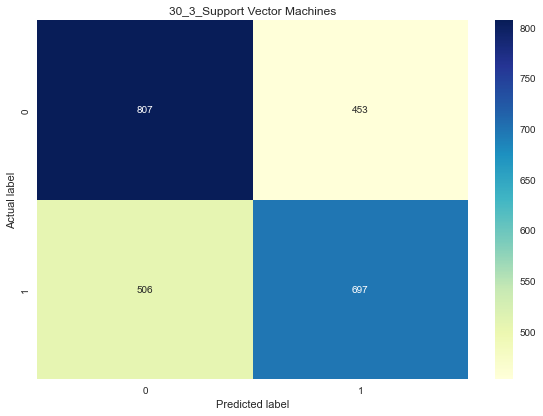

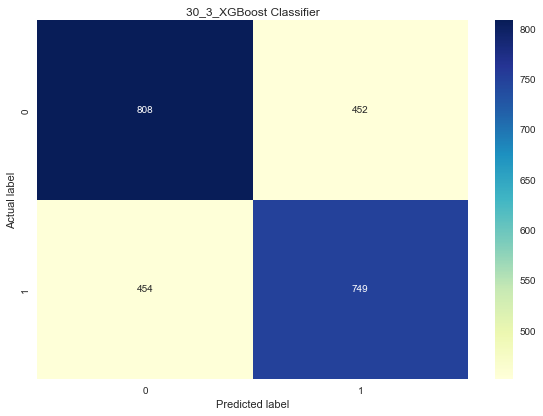

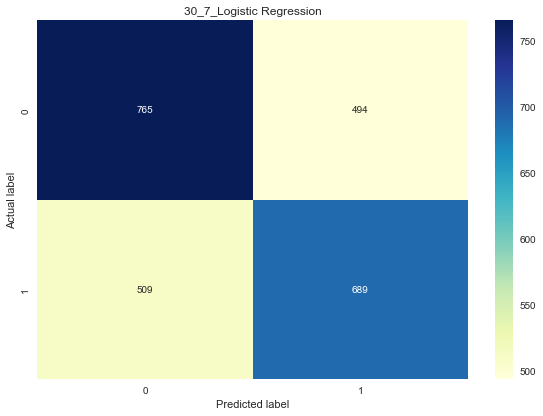

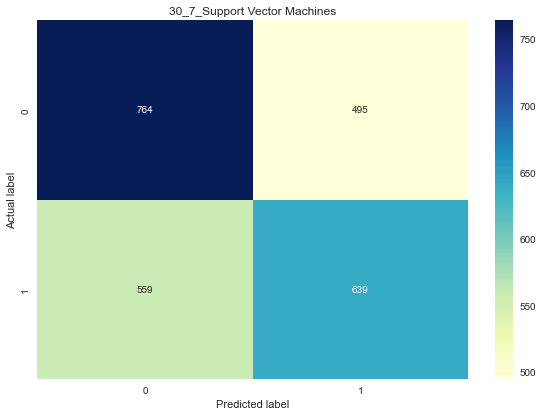

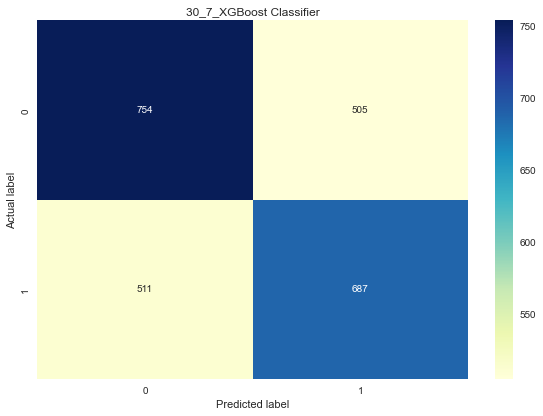

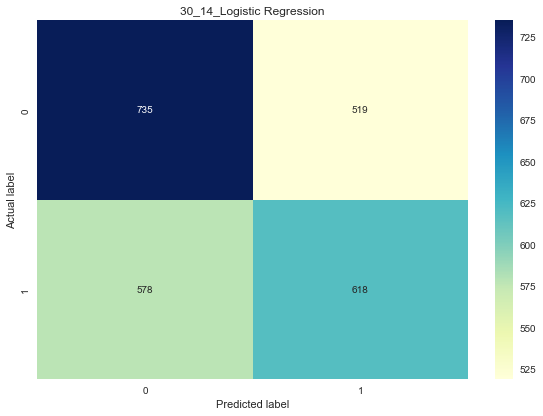

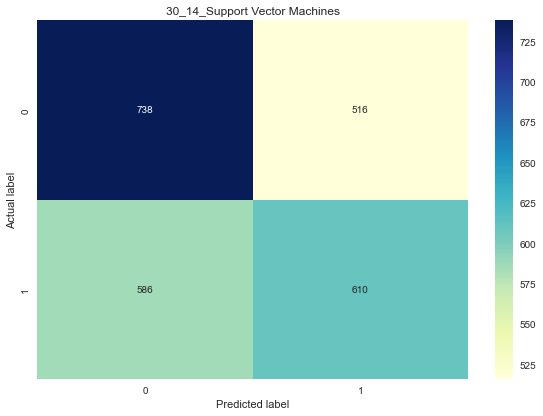

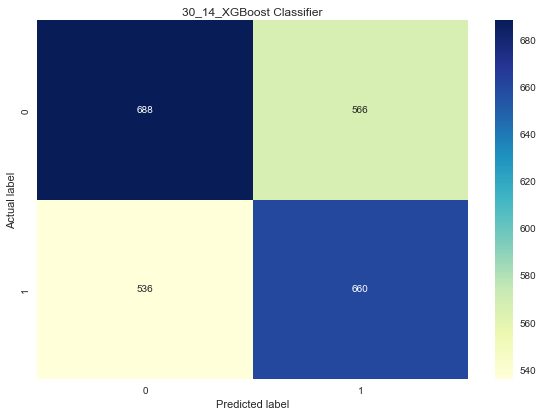

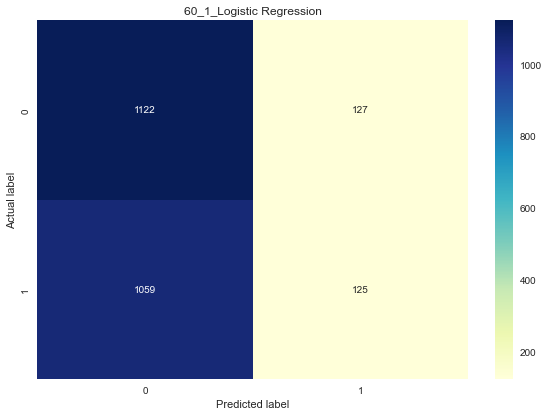

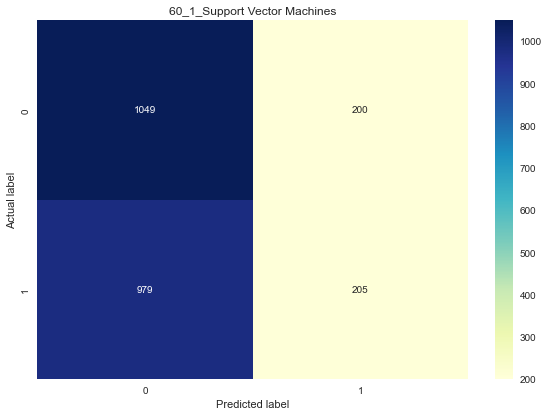

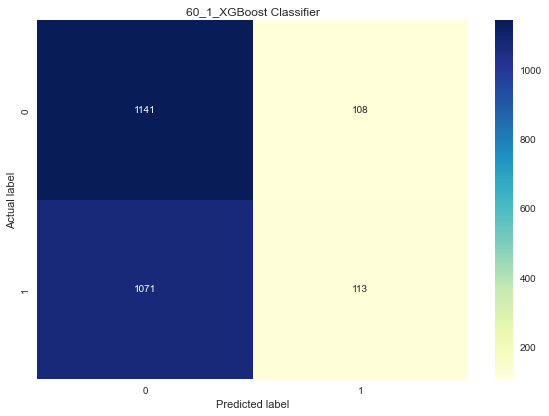

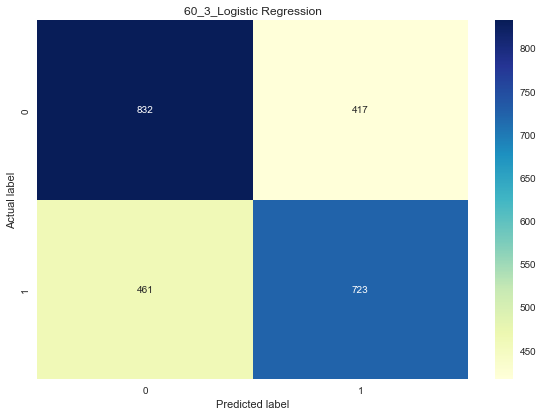

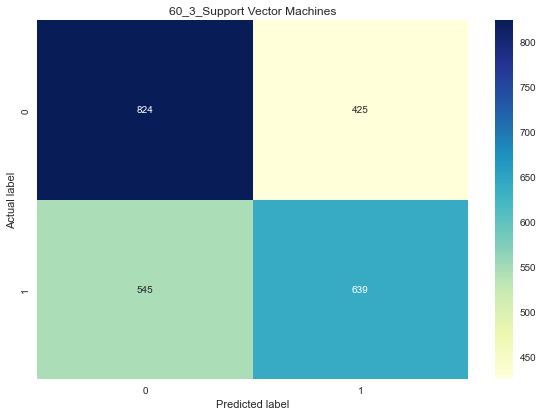

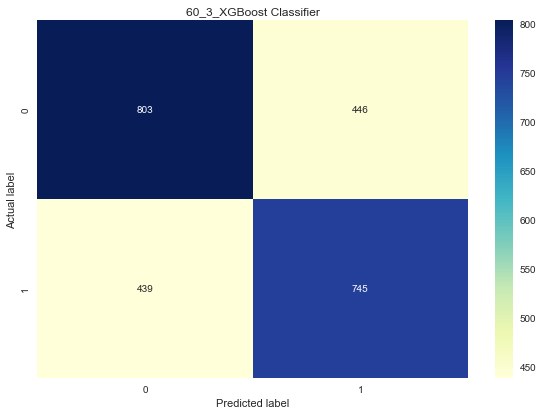

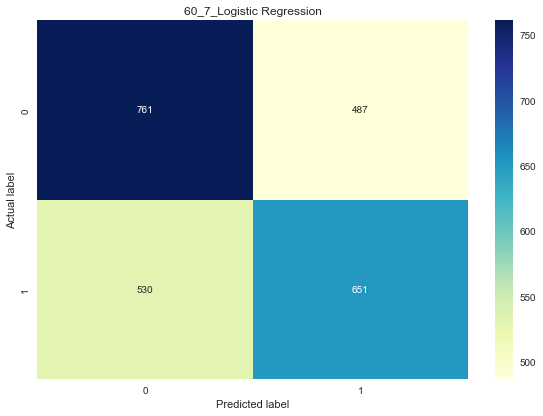

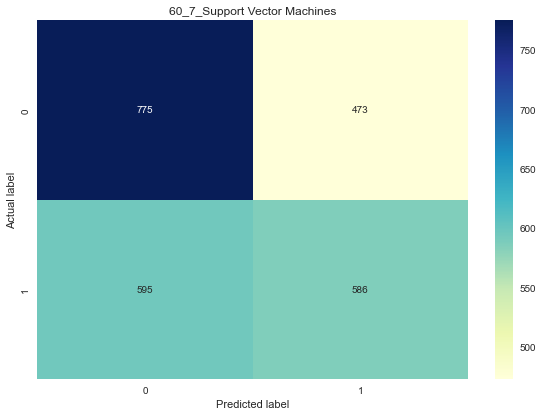

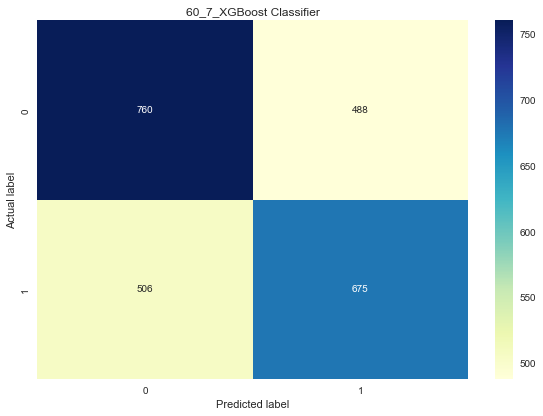

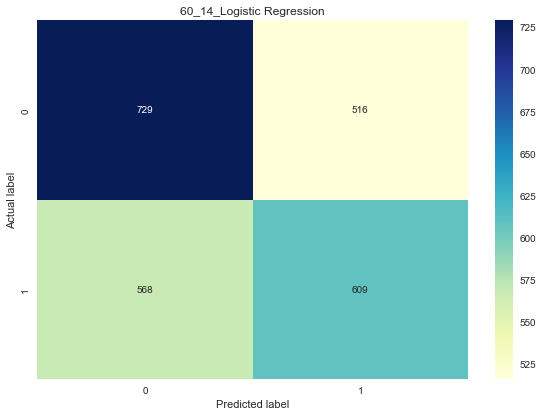

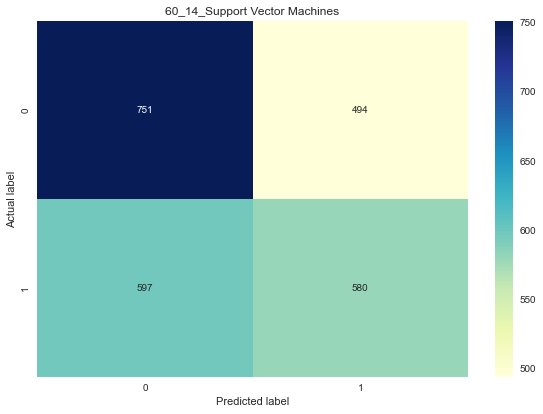

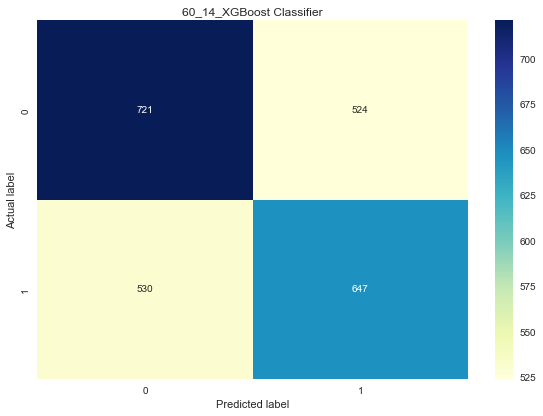

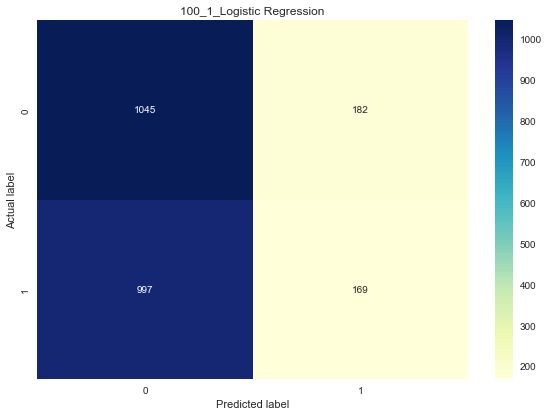

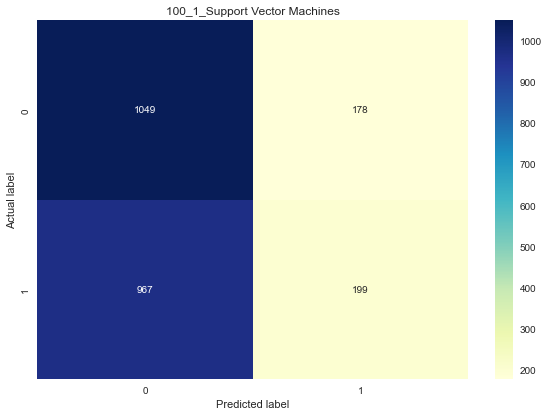

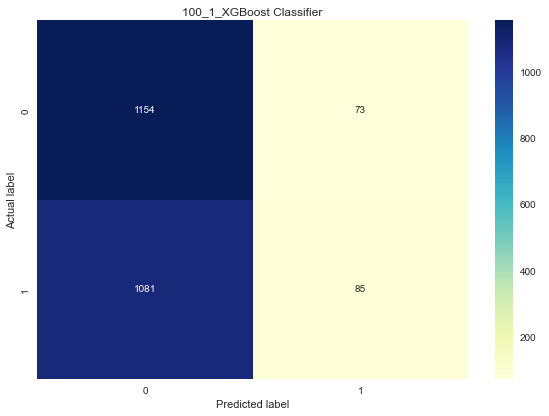

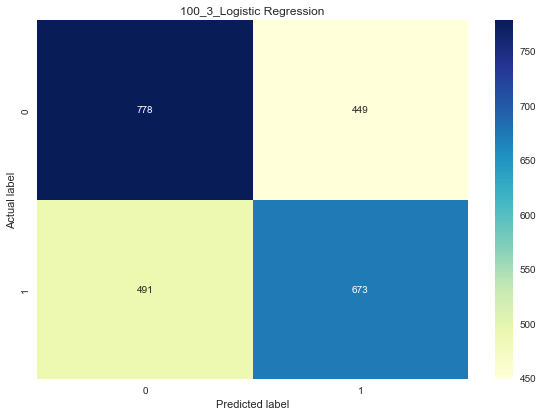

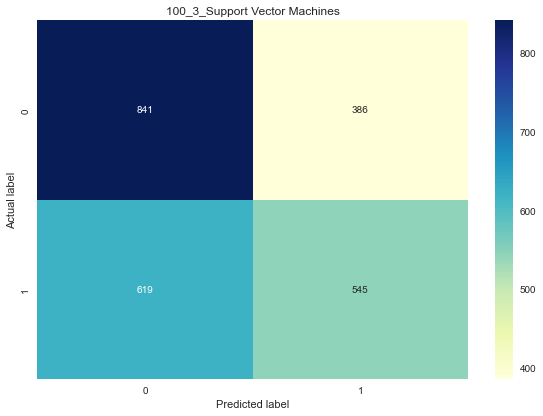

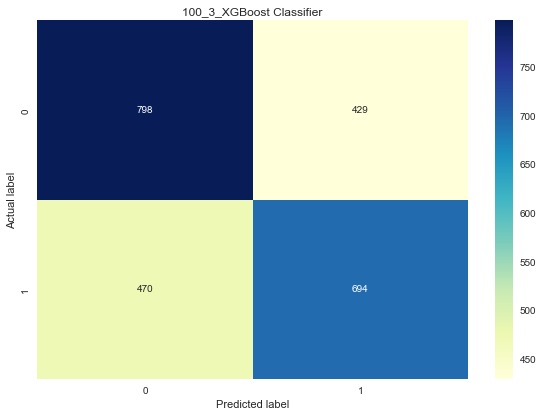

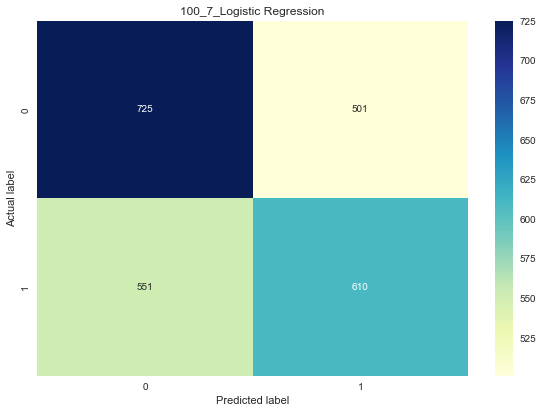

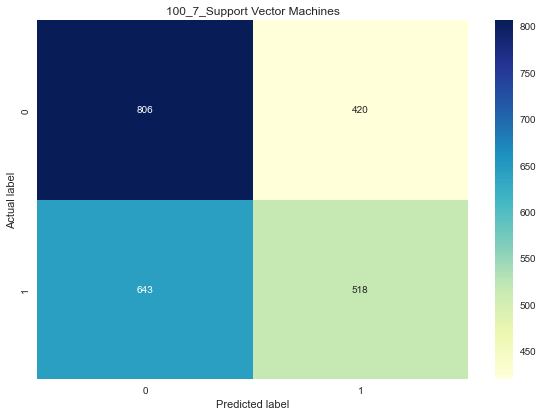

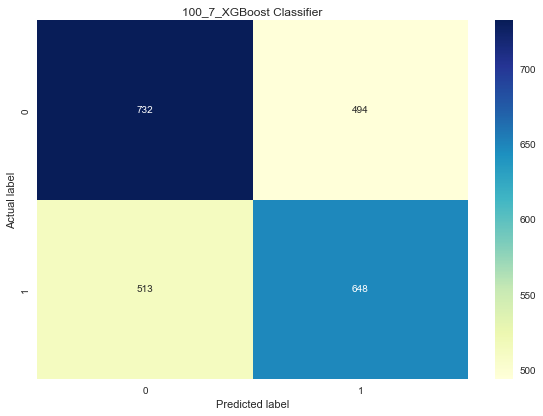

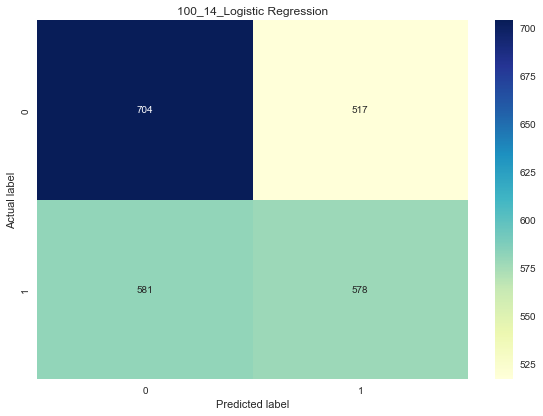

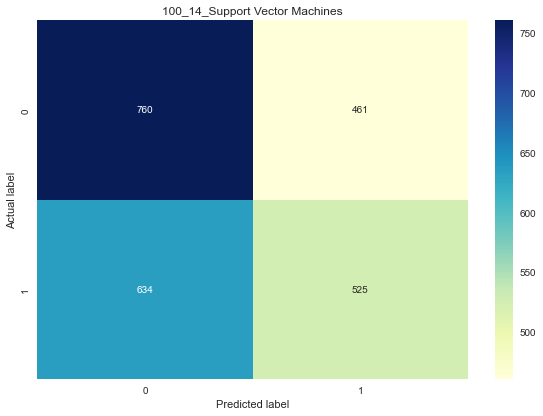

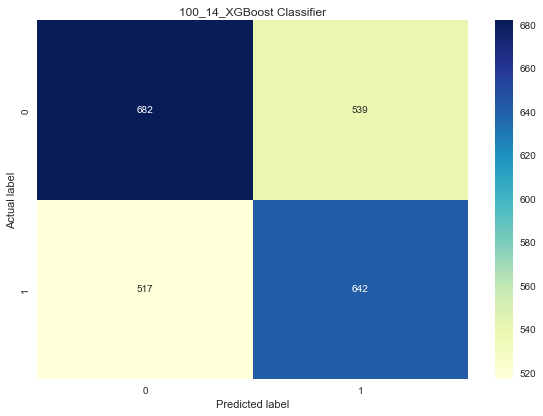

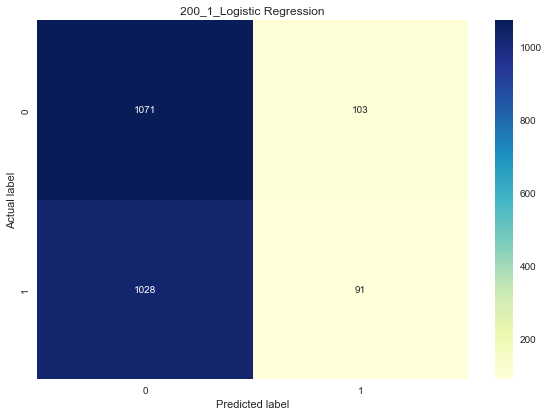

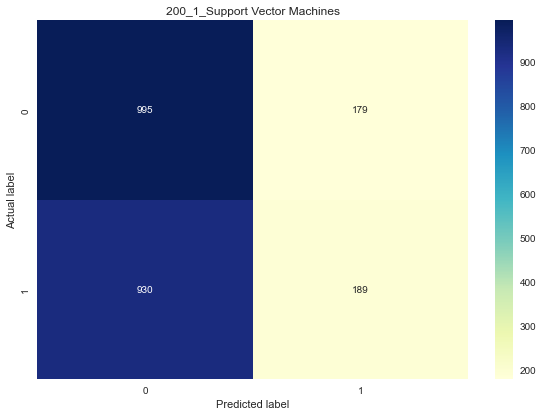

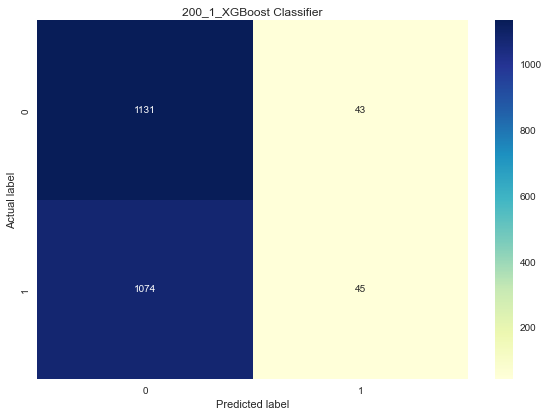

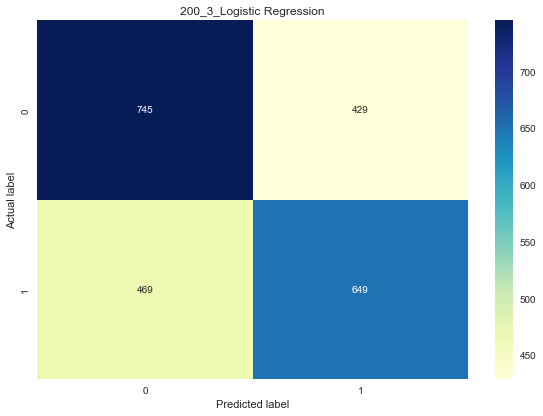

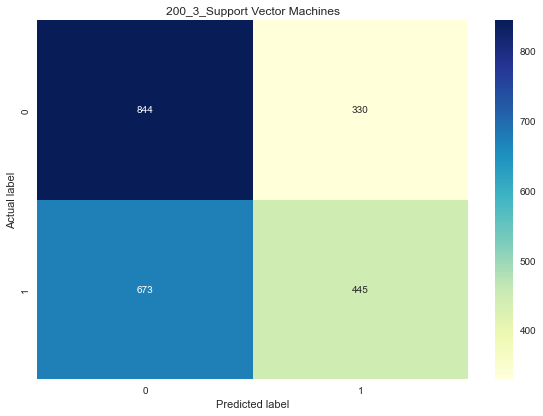

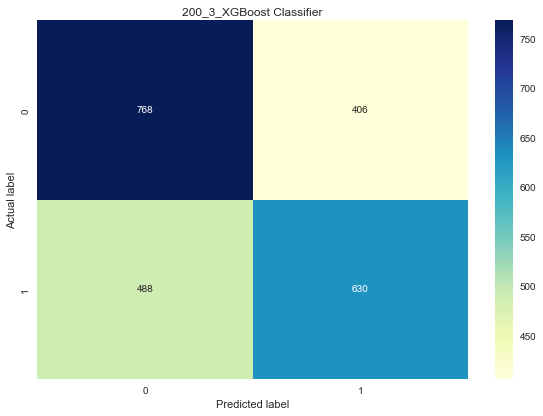

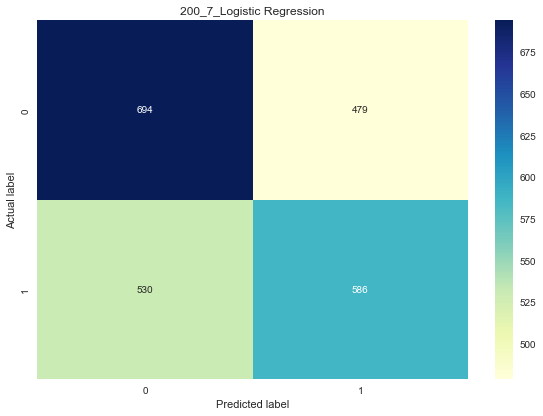

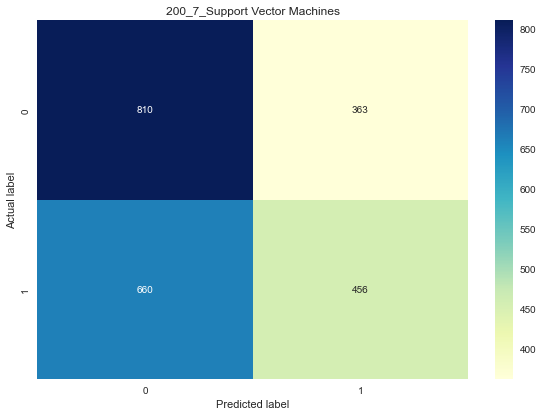

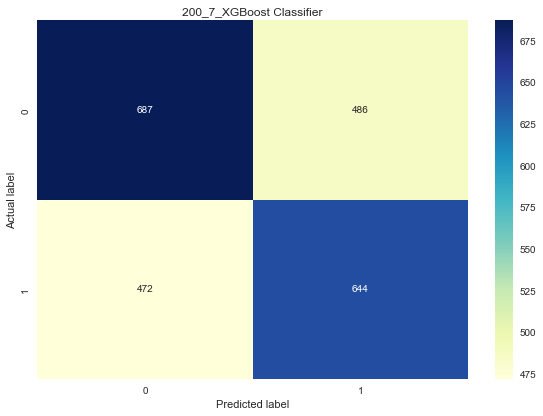

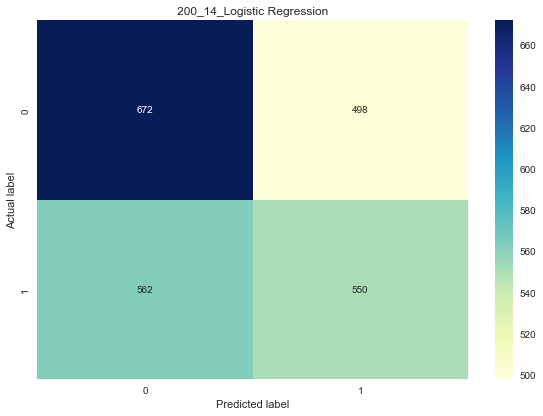

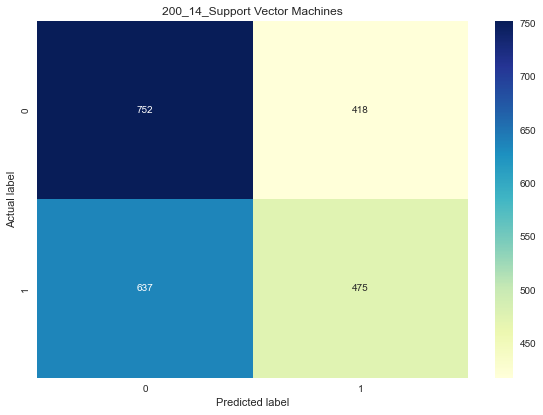

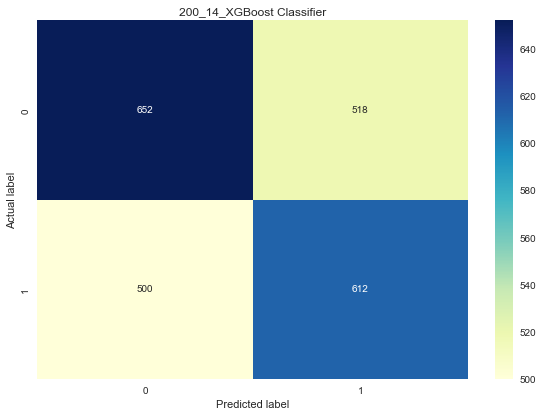

In [23]:
# Visualise confusion matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
class_names=['UP', 'DOWN'] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

for i in cm:
# create heatmap
    sns.heatmap(pd.DataFrame(cm[i]), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title(i)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

# Parameter tuning

In [169]:
from parameter_tunining import find_best_params
from TimeBasedCV import TimeBasedCV
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression

# params = {
#     'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#     'C': [0.5, 1, 3] 
# }

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [1.0, 0.1, 0.01]

params = dict(solver=solvers,penalty=penalty,C=c_values)

tscv = TimeBasedCV(train_period=30, test_period=3)

split_indices = tscv.split(dataset_1, gap=1)

lr_best_params = find_best_params(
    estimator=LogisticRegression(), 
    params=params, 
    split_indices=split_indices, 
    features=dataset_1, 
    outcomes=outcomes_eth['direction_1']
    )

lr_best_params

d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 823 folds for each of 9 candidates, totalling 7407 fits


d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.01}

# LSTM

In [162]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

features_eth_lstm = ohlcv_eth[['date', 'high', 'low', 'open', 'volumefrom', 'close']]
# outcomes_eth = pd.DataFrame(ohlcv_eth['date'])

# outcomes_eth.loc[:, 'close_1'] = ohlcv_eth[['date', 'close']].set_index('date').pct_change(-1)
# outcomes_eth.loc[:, 'direction_1'] = outcomes_eth.loc[:, 'close_1'].apply(lambda x: 1 if x > 0 else (0 if x < 0 else None))
outcomes_eth_lagged = outcomes_eth.shift(-1)

training_set = features_eth_lstm[:2000].drop('date', axis=1).values
validation_set = features_eth_lstm[2000:2400].drop('date', axis=1).values
testing_set = features_eth_lstm[2400:].drop('date', axis=1)

sc = MinMaxScaler(feature_range = (0, 1))
training_set = sc.fit_transform(training_set)
validation_set = sc.fit_transform(validation_set)

X_train = []
y_train = []
X_val = []
y_val = []


for i in range(60, len(training_set)- 1):
    X_train.append(training_set[i-60:i, :])
    y_train.append(outcomes_eth_lagged['direction_1'][i])
X_train, y_train = np.array(X_train), np.array(y_train)


for i in range(60, len(validation_set)- 1):
    X_val.append(validation_set[i-60:i, 4])
    y_val.append(outcomes_eth_lagged['direction_1'][i])
X_val, y_val = np.array(X_train), np.array(y_train)



X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))


ValueError: cannot reshape array of size 581700 into shape (1939,60,1)

In [166]:

import numpy as np
np.random.seed(1)
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers import LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')


#Build and train the model
def fit_model(train, val, timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
    
    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]), return_sequences = True,
                   activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
    model.add(LSTM(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'binary_crossentropy')
    #print(model.summary())
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs=epochs, batch_size=batch, validation_data=(X_val, Y_val), verbose=1,
                        shuffle = False)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']


train = features_eth_lstm[:2000].drop('date', axis=1).values
val = features_eth_lstm[2000:2400].drop('date', axis=1).values
test = features_eth_lstm[2400:].drop('date', axis=1)

timesteps = 50
hl = [40,35]
lr = 1e-3
batch_size = 64
num_epochs = 20

model, train_error, val_error = fit_model(train, val, timesteps, hl, lr, batch_size, num_epochs)



Epoch 1/20


d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


31/31 [==============================] - 27s 769ms/step - loss: 1328.5490 - val_loss: 11037.2354
Epoch 2/20
31/31 [==============================] - 26s 816ms/step - loss: 1328.5490 - val_loss: 11037.2354
Epoch 3/20
31/31 [==============================] - 35s 1s/step - loss: 1328.5490 - val_loss: 11037.2354
Epoch 4/20
31/31 [==============================] - 25s 799ms/step - loss: 1328.5490 - val_loss: 11037.2354
Epoch 5/20
 4/31 [==>...........................] - ETA: 29s - loss: 25.3144

KeyboardInterrupt: 

In [149]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

array([[6.55500e-01, 6.11600e-01, 6.20500e-01, ..., 8.25400e-01,
        8.22600e-01, 8.41200e-01],
       [6.11600e-01, 6.20500e-01, 6.48900e-01, ..., 8.22600e-01,
        8.41200e-01, 8.51900e-01],
       [6.20500e-01, 6.48900e-01, 6.26900e-01, ..., 8.41200e-01,
        8.51900e-01, 8.36300e-01],
       ...,
       [1.23410e+03, 1.39245e+03, 1.31847e+03, ..., 1.78394e+03,
        1.68205e+03, 1.66869e+03],
       [1.39245e+03, 1.31847e+03, 1.36822e+03, ..., 1.68205e+03,
        1.66869e+03, 1.58324e+03],
       [1.31847e+03, 1.36822e+03, 1.24151e+03, ..., 1.66869e+03,
        1.58324e+03, 1.58698e+03]])

In [146]:
print(outcomes_eth.shift(-1).head())

outcomes_eth.head()


        date symbol   close_1  direction_1   close_2  direction_2   close_3  \
0 2015-10-07    ETH -0.014343          0.0 -0.057482          0.0 -0.024406   
1 2015-10-08    ETH -0.043766          0.0 -0.010209          0.0 -0.021602   
2 2015-10-09    ETH  0.035093          1.0  0.023179          1.0  0.034268   
3 2015-10-10    ETH -0.011511          0.0 -0.000797          0.0  0.039118   
4 2015-10-11    ETH  0.010838          1.0  0.051218          1.0  0.240610   

   direction_3   close_4  direction_4   close_5  direction_5   close_6  \
0          0.0 -0.035635          0.0 -0.025183          0.0  0.013758   
1          0.0 -0.010998          0.0  0.028510          1.0  0.213811   
2          1.0  0.075584          1.0  0.269366          1.0  0.160823   
3          1.0  0.226330          1.0  0.121467          1.0  0.178827   
4          1.0  0.134526          1.0  0.192554          1.0  0.158991   

   direction_6   close_7  direction_7  
0          1.0  0.196401          1.0  


,date,symbol,close_1,direction_1,close_2,direction_2,close_3,direction_3,close_4,direction_4,close_5,direction_5,close_6,direction_6,close_7,direction_7
0,2015-10-06,ETH,0.071779,1.0,0.056406,1.0,0.010171,1.0,0.045621,1.0,0.033586,1.0,0.044788,1.0,0.086524,1.0
1,2015-10-07,ETH,-0.014343,0.0,-0.057482,0.0,-0.024406,0.0,-0.035635,0.0,-0.025183,0.0,0.013758,1.0,0.196401,1.0
2,2015-10-08,ETH,-0.043766,0.0,-0.010209,0.0,-0.021602,0.0,-0.010998,0.0,0.028510,1.0,0.213811,1.0,0.110018,1.0
3,2015-10-09,ETH,0.035093,1.0,0.023179,1.0,0.034268,1.0,0.075584,1.0,0.269366,1.0,0.160823,1.0,0.220196,1.0
4,2015-10-10,ETH,-0.011511,0.0,-0.000797,0.0,0.039118,1.0,0.226330,1.0,0.121467,1.0,0.178827,1.0,0.145651,1.0


In [104]:
import numpy as np

# np.log(ohlcv_eth['close'] / ohlcv_eth['close'].shift(1))

ohlcv_eth['close'].head(10)

0    0.6555
1    0.6116
2    0.6205
3    0.6489
4    0.6269
5    0.6342
6    0.6274
7    0.6033
8    0.5112
9    0.5590
Name: close, dtype: float64

# Archive (Just in case)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import svm
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense


standard_scaler = StandardScaler()

split_point = int(0.80*len(features_eth))

features = features_eth_blockchain.merge(features_eth, on='date')
target = outcomes_eth['direction_5']
# train_dataset = features_eth.join(outcomes_eth['direction_1']).iloc[:split_point,:]

X_train = features.iloc[:split_point, :]
y_train = target.iloc[:split_point]

X_test = features.iloc[split_point:, :] 
y_test = target.iloc[split_point:]

# Transform training dataset
X_train = standard_scaler.fit_transform(X_train)

# Transform test dataset
X_test = standard_scaler.fit_transform(X_test)

# model = LogisticRegression()
model = svm.SVC(kernel='linear', C=1000)


model.fit(X=X_train, y=y_train)

print('Accuracy in-sample: {}'.format(model.score(X=X_train, y=y_train)))
print('Accuracy out-of-sample: {}'.format(model.score(X=X_test, y=y_test)))
# print('Coefficients: {}'.format(model.coef_))

y_pred = model.predict(X_test)

confusion_matrix(y_true=y_test, y_pred=y_pred)

# plt.style.use('ggplot')
# plt.figure(figsize=(15,7))
# plt.plot(y_test, label='Actual')
# plt.plot(y_pred, label='Predicted')
# plt.legend()
# plt.show()

Accuracy in-sample: 0.6290890790135883
Accuracy out-of-sample: 0.4768611670020121


array([[158, 103],
       [157,  79]], dtype=int64)

### Expanding and Rolling Window techniques

In [ ]:
from run_predictions import fit_expanding_window, predict_expanding_window, fit_rolling_window, predict_rolling_window
from sklearn.linear_model import LinearRegression, LogisticRegression

models_expanding_window = fit_expanding_window(features_eth, outcomes_eth['direction_1'], model_instance=LogisticRegression())
predictions_expanding_window = predict_expanding_window(models_expanding_window, features_eth)

models_rolling_window = fit_rolling_window(features_eth, outcomes_eth['direction_1'], model_instance=LogisticRegression())
predictions_rolling_window = predict_rolling_window(models_rolling_window, features_eth)


Predicting for the period between 2015-10-31 00:00:00 and 2015-11-30 00:00:00

Predicting for the period between 2015-11-30 00:00:00 and 2015-12-31 00:00:00

Predicting for the period between 2015-12-31 00:00:00 and 2016-01-31 00:00:00

Predicting for the period between 2016-01-31 00:00:00 and 2016-02-29 00:00:00

Predicting for the period between 2016-02-29 00:00:00 and 2016-03-31 00:00:00

Predicting for the period between 2016-03-31 00:00:00 and 2016-04-30 00:00:00

Predicting for the period between 2016-04-30 00:00:00 and 2016-05-31 00:00:00

Predicting for the period between 2016-05-31 00:00:00 and 2016-06-30 00:00:00

Predicting for the period between 2016-06-30 00:00:00 and 2016-07-31 00:00:00

Predicting for the period between 2016-07-31 00:00:00 and 2016-08-31 00:00:00

Predicting for the period between 2016-08-31 00:00:00 and 2016-09-30 00:00:00

Predicting for the period between 2016-09-30 00:00:00 and 2016-10-31 00:00:00

Predicting for the period between 2016-10-31 00:00:0